In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 1: imports & settings
# ─────────────────────────────────────────────────────────────────────────────
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import torch
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt
import tqdm
import seaborn

import scipy
from statsmodels.stats.multitest import multipletests
import antipode
from antipode.antipode_model import ANTIPODE
import antipode.model_functions as mf

# add any custom utility paths
sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis

# figure directory
FIGDIR = Path.home() / 'WbFigures' / 'DevSignaling'
FIGDIR.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = str(FIGDIR)
sc._settings.settings._vector_friendly = True

# matplotlib defaults
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.family': 'DejaVu Sans',
    'font.sans-serif': 'DejaVuSansMono',
    'pdf.fonttype': 42,
})

# register your custom colormap
cmap = matplotlib.colors.ListedColormap(sc.pl.palettes.godsnot_102, name='godsnot_102')
try:
    matplotlib.colormaps.register(name='godsnot_102', cmap=cmap)
except ValueError:
    pass

# GPU?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
np.random.seed(13)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2: load AnnData & model
# ─────────────────────────────────────────────────────────────────────────────
MODEL_TAG   = '1.9.1.8.5_Dev_final_600clusters'
MODEL_PATH = Path('/home/matthew.schmitz/Matthew/models') / MODEL_TAG
adata      = sc.read_h5ad(str(MODEL_PATH / 'analysis_inprogress.h5ad'))

# antipode_model = ANTIPODE.load(str(MODEL_PATH), adata=adata, prefix='p3_', device=device)
# antipode_model.save_params_to_uns()
# adata = antipode_model.adata_manager.adata

In [3]:
# lol crazy plotting functions
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Patch
import tqdm
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import math
import matplotlib.patheffects as pe


def plot_tile_heatmap(data, dim_0_names, dim_1_names, dim_2_names, mini_grid_dims=None, 
                      cell_size=1, cmap_name='tab20', heavy_linewidth=2, light_linewidth=0.2,font_size=10,save_path=None,
                      legend_square_size = 0.4,legend_font_size = 7,legend_pad = 0.03
):
    """
    Plot a nested heatmap where each cell (grid pair) is subdivided into mini tiles
    representing ligand–receptor interaction strengths, and adds a legend for ligands.
    
    Parameters
    ----------
    data : np.ndarray
        3D array of shape (n_rows, n_cols, n_ligands) with values in [0, 1].
    dim_0_names : list of str
        Labels for the rows (y-axis). Length should equal n_rows.
    dim_1_names : list of str
        Labels for the columns (x-axis). Length should equal n_cols.
    dim_2_names : list of str
        Names for each ligand (used to assign colors and for the legend).
    mini_grid_dims : tuple of ints, optional
        Dimensions (rows, cols) of the mini grid inside each cell. If None, the grid
        will be as square as possible.
    cell_size : float, optional
        The size of each cell in the heatmap.
    cmap_name : str, optional
        Name of a qualitative colormap (e.g. 'tab20') to assign each ligand a unique base color.
    heavy_linewidth : float, optional
        Line width for the boundaries between cells.
    light_linewidth : float, optional
        Line width for the subgrid (mini-tile) borders.
    """
    n_rows_data, n_cols_data, n_ligands = data.shape

    # Validate that provided labels match the data dimensions.
    if len(dim_0_names) != n_rows_data:
        raise ValueError(f"Expected {n_rows_data} row labels (dim_0_names), but got {len(dim_0_names)}.")
    if len(dim_1_names) != n_cols_data:
        raise ValueError(f"Expected {n_cols_data} column labels (dim_1_names), but got {len(dim_1_names)}.")

    # Determine mini-grid dimensions (rows x cols) for subdividing each cell.
    if mini_grid_dims is None:
        n_rows = int(np.floor(np.sqrt(n_ligands)))
        n_rows = max(n_rows, 1)
        n_cols = int(np.ceil(n_ligands / n_rows))
    else:
        n_rows, n_cols = mini_grid_dims

    # Get base colors for each ligand using the specified qualitative colormap.
    cmap = plt.get_cmap(cmap_name)
    base_colors = [cmap(i / n_ligands) for i in range(n_ligands)]
    
    # Create figure and axis.
    fig, ax = plt.subplots(figsize=(n_cols_data * cell_size, n_rows_data * cell_size))
    ax.set_xlim(0, n_cols_data * cell_size)
    ax.set_ylim(0, n_rows_data * cell_size)
    ax.set_aspect('equal')
    # Invert y-axis so that the first row appears at the top.
    ax.invert_yaxis()
    
    # Loop over each cell in the grid.
    for i in tqdm.tqdm(range(n_rows_data)):
        for j in range(n_cols_data):
            cell_x = j * cell_size
            cell_y = i * cell_size
            # Draw heavy border for the cell.
            ax.add_patch(patches.Rectangle((cell_x, cell_y), cell_size, cell_size, 
                                           fill=False, edgecolor='black', lw=heavy_linewidth))
            # Dimensions of each mini-tile.
            tile_w = cell_size / n_cols
            tile_h = cell_size / n_rows
            # Loop over each ligand (mini-tile).
            for k in range(n_ligands):
                mini_row = k // n_cols
                mini_col = k % n_cols
                tile_x = cell_x + mini_col * tile_w
                # Remove the inversion of mini_row to flip the order relative to the legend.
                tile_y = cell_y + mini_row * tile_h
                v = data[i, j, k]
                base = np.array(base_colors[k][:3])  # Drop alpha if present.
                color = (1 - v) * np.array([1, 1, 1]) + v * base
                ax.add_patch(patches.Rectangle((tile_x, tile_y), tile_w, tile_h, 
                                               facecolor=color, edgecolor='gray', lw=light_linewidth))
    
    # Set tick positions: columns on x-axis and rows on y-axis.
    xticks = np.arange(cell_size/2, n_cols_data * cell_size, cell_size)
    yticks = np.arange(cell_size/2, n_rows_data * cell_size, cell_size)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    # For rectangular grids, use dim_1_names for x-axis (columns) and dim_0_names for y-axis (rows).
    ax.set_xticklabels(dim_1_names,rotation=90)
    ax.set_yticklabels(dim_0_names)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    
    # Create a legend with color patches for each ligand.
    legend_handles = [patches.Patch(color=base_colors[k], label=dim_2_names[k]) 
                      for k in range(n_ligands)]
    # 1) get heatmap bbox, grid dims, and colors
    pos       = ax.get_position()   # [left, bottom, width, height] in fig‐fraction
    # n_rows, n_cols already computed for your mini-tiles
    # base_colors is your list of RGBA tuples
    # dim_2_names is your list of labels
    # font_size is already set

    # 2) pick a real‐world square size (in inches) for each text cell

    # 3) get figure dimensions (in inches)
    fig_w, fig_h = fig.get_size_inches()

    # 4) compute legend axes size in fig‐fraction
    legend_w = (legend_square_size * n_cols) / fig_w
    legend_h = (legend_square_size * n_rows * 0.4) / fig_h

    # 5) compute lower‐left corner so legend is vertically centered
    x0 = pos.x1 + legend_pad
    y0 = pos.y0 + (pos.height - legend_h) / 2

    # 6) create tiny axes for the grid of labels
    legend_ax = fig.add_axes([x0, y0, legend_w, legend_h])
    legend_ax.set_xlim(0, n_cols)
    legend_ax.set_ylim(0, n_rows)
    legend_ax.invert_yaxis()   # row 0 at top
    legend_ax.axis('off')      # no ticks, no frame

    # 7) draw each label, colored appropriately
    for k, name in enumerate(dim_2_names):
        col = k % n_cols
        row = k // n_cols
        legend_ax.text(
            col + 0.5, row + 0.5, name,
            ha='center', va='center',
            rotation=0,                 # horizontal text
            color=base_colors[k],       # your ligand color
            fontsize=legend_font_size,
            fontweight='bold',
            path_effects=[pe.withStroke(linewidth=0.3, foreground="black")],
            wrap=True                    # if very long, wrap inside cell
        )

    # 8) save with tight bbox so nothing is clipped
    plt.tight_layout()
    if save_path is not None:
        fig.savefig(
            save_path,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1
        )
    plt.show()


def plot_tricolor_heatmap(data, x_tick_labels=None, y_tick_labels=None,color_axes=['Blue','Red','Yellow'],
                          heatmap_figsize=(10, 4), legend_figsize=(6, 6),save_prefix=None):
    """
    Plots a tricolor (RBY) heatmap using the mapping:
      R = 1 - a
      G = 1 - (a + b)
      B = 1 - (b + c)
    where data is a (3, height, width) array. This mapping gives:
      [max, 0, 0] -> blue   (0,0,1)
      [0, max, 0] -> red    (1,0,0)
      [0, 0, max] -> yellow (1,1,0)
    with white at [0,0,0] and black at [max,max,max].
    
    It also creates a ternary legend (in a separate figure) illustrating the 
    color gradient with the vertices labeled.
    
    Parameters:
      data            : np.array of shape (3, height, width)
      x_tick_labels   : list/array of x-axis tick labels (rotated 90°)
      y_tick_labels   : list/array of y-axis tick labels
      heatmap_figsize : tuple for the heatmap figure size (default (10,4))
      legend_figsize  : tuple for the legend figure size (default (6,6))
    """
    # -----------------------------
    # Part 1: Create and plot the tricolor heatmap
    # -----------------------------
    # Normalize the data so that the maximum value is 1.
    data_norm = data / np.max(data)
    
    # Unpack channels:
    a = data_norm[0, :, :]  # will control blue
    b = data_norm[1, :, :]  # will control red
    c = data_norm[2, :, :]  # will control yellow
    
    # Mapping from (a, b, c) to RGB:
    #   [max, 0, 0] (a=1)  -> blue:   (0,0,1)
    #   [0, max, 0] (b=1)  -> red:    (1,0,0)
    #   [0, 0, max] (c=1)  -> yellow: (1,1,0)
    # with white at [0,0,0] and black at [max, max, max].
    R = 1 - a
    G = 1 - (a + b)
    B = 1 - (b + c)
    
    # Clip values to ensure valid RGB in [0,1]
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)
    
    # Form the image with shape (height, width, 3)
    img = np.stack([R, G, B], axis=2)
    
    plt.figure(figsize=heatmap_figsize)
    plt.imshow(img)
    plt.title("Tricolor Heatmap (RBY)")
    if x_tick_labels is not None:
        plt.xticks(ticks=np.arange(len(x_tick_labels)), labels=x_tick_labels, rotation=90)
    if y_tick_labels is not None:
        plt.yticks(ticks=np.arange(len(y_tick_labels)), labels=y_tick_labels)
    else:
        plt.yticks([])
    plt.tight_layout()
    if save_prefix is not None:
        plt.savefig(save_prefix+'_heatmap.svg')
    plt.show()
    
    # -----------------------------
    # Part 2: Create a triangular (ternary) legend
    # -----------------------------
    # The legend shows a ternary plot where each vertex corresponds to:
    #   (a=1, b=0, c=0) -> blue   (0,0,1)
    #   (a=0, b=1, c=0) -> red    (1,0,0)
    #   (a=0, b=0, c=1) -> yellow (1,1,0)
    def project(a, b, c):
        # Center the point by subtracting the mean (to handle translation invariance)
        mu = (a + b + c) / 3.0
        a_prime = a - mu
        b_prime = b - mu
        c_prime = c - mu
        # Apply affine projection:
        #   T(1,0,0) -> (0, 1)   [blue]
        #   T(0,1,0) -> (sqrt3/2, -1/2)  [red]
        #   T(0,0,1) -> (-sqrt3/2, -1/2) [yellow]
        x = (np.sqrt(3) / 2) * (b_prime - c_prime)
        y = a_prime - 0.5 * (b_prime + c_prime)
        return x, y
    
    # Generate many points uniformly in the simplex S (a+b+c <= 1)
    N = 500000  # number of random points for a smooth legend
    points = []
    colors = []
    for _ in range(N):
        pt = np.random.rand(3)
        if pt.sum() <= 1:
            a_pt, b_pt, c_pt = pt
            # Compute color according to RBY mapping:
            R_pt = 1 - a_pt
            G_pt = 1 - (a_pt + b_pt)
            B_pt = 1 - (b_pt + c_pt)
            R_pt = np.clip(R_pt, 0, 1)
            G_pt = np.clip(G_pt, 0, 1)
            B_pt = np.clip(B_pt, 0, 1)
            colors.append((R_pt, G_pt, B_pt))
            points.append((a_pt, b_pt, c_pt))
    points = np.array(points)
    colors = np.array(colors)
    
    # Project each (a, b, c) to 2D
    xy = np.array([project(a_pt, b_pt, c_pt) for a_pt, b_pt, c_pt in points])
    x_vals = xy[:, 0]
    y_vals = xy[:, 1]
    
    # Define vertices for the pure channels.
    x_blue, y_blue     = project(1, 0, 0)    # blue: [max,0,0]
    x_red, y_red       = project(0, 1, 0)    # red:  [0,max,0]
    x_yellow, y_yellow = project(0, 0, 1)    # yellow: [0,0,max]
    
    plt.figure(figsize=legend_figsize)
    plt.scatter(x_vals, y_vals, c=colors, s=10, marker='s', edgecolors='none', alpha=0.5)
    
    # Draw the boundary triangle connecting the three pure colors.
    triangle_x = [x_blue, x_red, x_yellow, x_blue]
    triangle_y = [y_blue, y_red, y_yellow, y_blue]
    plt.plot(triangle_x, triangle_y, color='black', lw=1.5)
    
    # Annotate vertices.
    plt.text(x_blue, y_blue + 0.05, f"[max,0,0]\n({color_axes[0]})", color='blue',
             fontsize=10, ha='center', va='bottom')
    plt.text(x_red, y_red - 0.05, f"[0,max,0]\n({color_axes[1]})", color='red',
             fontsize=10, ha='center', va='top')
    plt.text(x_yellow, y_yellow - 0.05, f"[0,0,max]\n({color_axes[2]})", color='goldenrod',
             fontsize=10, ha='center', va='top')
    
    # Mark the center (which represents [0,0,0] white)
    plt.scatter(0, 0, s=50, color='white', edgecolor='black', zorder=10)
    plt.text(0, 0.05, "[0,0,0]", color='black', fontsize=10, ha='center', va='bottom')
    
    plt.axis('off')
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    if save_prefix is not None:
        plt.savefig(save_prefix+'_legend.svg')
    plt.show()

def boost_to_black(rgb, exponent=2.0):
    """
    rgb: array (..., 3) in [0,1]
    exponent > 1 makes darkening kick in more sharply at low brightness.
    
    We compute per‐pixel mean brightness m = (r+g+b)/3,
    then compute a “darkening weight” alpha = (1 - m)**exponent,
    and finally blend each channel c -> c' = c * (1 - alpha).
    """
    # mean brightness in [0,1]
    m = np.mean(rgb, axis=-1, keepdims=True)    # shape (...,1)
    alpha = (1 - m) ** exponent                  # darkening strength
    return np.clip(rgb * (1 - alpha), 0, 1)


def compute_tricolor_rgb_4d(data,rby=True,black_exp=1.0):
    """
    data: np.ndarray, shape (3, n_rows, n_cols, n_ligands), values in [0,1].
    Returns: np.ndarray of shape (n_rows, n_cols, n_ligands, 3), with
      R = clip(1 - a,      0,1)
      G = clip(1 - (a + b),0,1)
      B = clip(1 - (b + c),0,1)
    exactly as in your original heatmap.
    """
    data = np.asarray(data)
    if data.ndim != 4 or data.shape[0] != 3:
        raise ValueError("Expected data of shape (3, rows, cols, ligands).")
    if np.any(data < 0) or np.any(data > 1):
        raise ValueError("All values must lie in [0,1].")

    a = data[0]   # species 1
    b = data[1]   # species 2
    c = data[2]   # species 3
    if rby:
        R = np.clip(1 - a,       0, 1)
        G = np.clip(1 - (a + b), 0, 1)
        B = np.clip(1 - (b + c), 0, 1)
    else:
        R = np.clip(a,       0, 1)
        G = np.clip(b, 0, 1)
        B = np.clip(c, 0, 1)

    # stack into last axis → shape (rows, cols, ligands, 3)
    return boost_to_black(np.stack([R, G, B], axis=-1), exponent=black_exp)

def plot_tricolor_legend_4d(color_axes=['Blue','Red','Yellow'],
                            legend_figsize=(6,6),
                            N=200_000,rby=True,black_exp=1.,
                            save_prefix=None):
    """
    Ternary legend sampling from compute_tricolor_rgb_4d.

    color_axes : names for the three vertices
    legend_figsize : figure size
    N : number of random samples in the simplex
    save_prefix : if given, legend is saved to '{save_prefix}_legend.svg'
    """
    def project(a, b, c):
        mu = (a + b + c) / 3.0
        a_p, b_p, c_p = a - mu, b - mu, c - mu
        x = (math.sqrt(3)/2) * (b_p - c_p)
        y = a_p - 0.5 * (b_p + c_p)
        return x, y

    # 1) sample N points in the simplex a+b+c<=1
    pts = []
    while len(pts) < N:
        pt = np.random.rand(3)
        if pt.sum() <= 1:
            pts.append(pt)
    pts = np.array(pts).T         # shape (3, K)
    K = pts.shape[1]

    # 2) reshape to a (3,1,1,K) array for compute_tricolor_rgb_4d
    data4d = pts.reshape(3, 1, 1, K)

    # 3) compute RGB via your 4D helper
    colors4d = compute_tricolor_rgb_4d(data4d,rby=rby,black_exp=black_exp)  # shape (1,1,K,3)
    colors = colors4d[0, 0, :, :]               # shape (K,3)

    # 4) project points into 2D
    xy = np.array([project(*pts[:, i]) for i in range(K)])
    x_vals, y_vals = xy[:, 0], xy[:, 1]

    # 5) get the three pure‐color vertices
    xb, yb   = project(1, 0, 0)  # species1=1 → blue vertex
    xr, yr   = project(0, 1, 0)  # species2=1 → red
    xy2, yy2 = project(0, 0, 1)  # species3=1 → yellow

    # 6) plot
    plt.figure(figsize=legend_figsize)
    plt.scatter(x_vals, y_vals, c=colors, s=8, marker='s',
                edgecolors='none', alpha=0.5)

    # triangle border
    tri_x = [xb, xr, xy2, xb]
    tri_y = [yb, yr, yy2, yb]
    plt.plot(tri_x, tri_y, color='black', lw=1.5)

    # annotations
    plt.text(xb, yb + 0.05, f"[max,0,0]\n({color_axes[0]})",
             color='blue', ha='center', va='bottom')
    plt.text(xr, yr - 0.05, f"[0,max,0]\n({color_axes[1]})",
             color='red', ha='center', va='top')
    plt.text(xy2, yy2 - 0.05, f"[0,0,max]\n({color_axes[2]})",
             color='goldenrod', ha='center', va='top')

    # white center
    # plt.scatter(0, 0, s=50, color='white', edgecolor='black', zorder=10)
    # plt.text(0, 0.05, "[0,0,0]", color='black',
    #          ha='center', va='bottom')

    plt.axis('off')
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_legend.png")
    plt.show()


def plot_tile_heatmap_rgb(tile_colors,
                      dim_0_names,
                      dim_1_names,
                      dim_2_names,
                      mini_grid_dims=None,
                      cell_size=1,
                      heavy_linewidth=2,
                      light_linewidth=0.2,
                      font_size=10,
                      save_path=None):
    """
    Plot a nested heatmap from a precomputed RGB array.

    tile_colors: ndarray of shape (n_rows, n_cols, n_ligands, 3)
    dim_0_names: list of length n_rows
    dim_1_names: list of length n_cols
    dim_2_names: list of length n_ligands  (only used for tile ordering)
    """
    n_rows, n_cols, n_ligands, _ = tile_colors.shape

    if len(dim_0_names) != n_rows:
        raise ValueError(f"Expected {n_rows} row labels, got {len(dim_0_names)}")
    if len(dim_1_names) != n_cols:
        raise ValueError(f"Expected {n_cols} col labels, got {len(dim_1_names)}")
    if len(dim_2_names) != n_ligands:
        raise ValueError(f"Expected {n_ligands} ligand names, got {len(dim_2_names)}")

    # choose mini-grid layout
    if mini_grid_dims is None:
        nr = max(int(np.floor(np.sqrt(n_ligands))), 1)
        nc = int(np.ceil(n_ligands / nr))
    else:
        nr, nc = mini_grid_dims

    fig, ax = plt.subplots(figsize=(n_cols * cell_size, n_rows * cell_size))
    ax.set_xlim(0, n_cols * cell_size)
    ax.set_ylim(0, n_rows * cell_size)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    tile_w = cell_size / nc
    tile_h = cell_size / nr

    for i in range(n_rows):
        for j in range(n_cols):
            x0, y0 = j * cell_size, i * cell_size
            # heavy border
            ax.add_patch(plt.Rectangle((x0, y0),
                                       cell_size, cell_size,
                                       fill=False,
                                       edgecolor='black',
                                       lw=heavy_linewidth))
            for k in range(n_ligands):
                r, c = divmod(k, nc)
                xx = x0 + c * tile_w
                yy = y0 + r * tile_h
                color = tile_colors[i, j, k]
                ax.add_patch(plt.Rectangle((xx, yy),
                                           tile_w, tile_h,
                                           facecolor=color,
                                           edgecolor='gray',
                                           lw=light_linewidth))

    # ticks & labels
    xt = np.arange(cell_size/2, n_cols * cell_size, cell_size)
    yt = np.arange(cell_size/2, n_rows * cell_size, cell_size)
    ax.set_xticks(xt)
    ax.set_yticks(yt)
    ax.set_xticklabels(dim_1_names, rotation=90)
    ax.set_yticklabels(dim_0_names)
    ax.tick_params(axis='both', which='major', labelsize=font_size)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 3: compute per‐species expression means
# ─────────────────────────────────────────────────────────────────────────────
def get_species_dataarray(adata, discov_key, leaf_key, layer_key):
    # returns DataArray dims=(species, leaf, gene)
    means, levels = mf.get_real_leaf_means(adata, discov_key, leaf_key, layer=layer_key)
    da = xr.DataArray(
        means,
        dims=['species', leaf_key, 'var'],
        coords={
            'species':            levels['species'],
            leaf_key:             levels[leaf_key],
            'var':                adata.var.index
        }
    )
    return da

species_means = get_species_dataarray(adata,
                                      discov_key='species',
                                      leaf_key='Initial_Class_markers',
                                      layer_key='spliced')

# linear‐space scaled per‐species
species_scaled = np.exp(species_means - species_means.max(('Initial_Class_markers')))
# differences per‐species (centered)
species_diff   = species_means - species_means.median(('species'))

100%|██████████| 98/98 [03:36<00:00,  2.21s/it]


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 4: ligand–receptor mapping
# ─────────────────────────────────────────────────────────────────────────────
GL_PATH='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/'
rl=pd.read_csv(os.path.join(GL_PATH,'MTS_neuropeptides_receptors.tsv'),sep='\t')
rl['type'] = rl['type'].str.split(',')
rl = rl.explode('type')
rl = rl.loc[rl['hgnc_symbol'].isin(species_means.coords['var'].values),:]

# separate
np_genes   = rl[rl['gene_class'].isin(['Neuropeptide'])]
receptors  = np_genes[np_genes['type'].str.endswith('-receiving')].copy()
ligands   = np_genes[~np_genes['type'].str.endswith('-receiving')]

receptors['complex'] = receptors['complex'].fillna(receptors['hgnc_symbol'])
receptors = (
    receptors
    .groupby(['complex','type','gene_class'])['hgnc_symbol']
    .apply('_'.join).reset_index()
)

pairs = []
for _, row in receptors.iterrows():
    lt = row['type'].replace('-receiving','')
    Ls = ligands[ligands['type']==lt]
    if not Ls.empty:
        for i in range(len(Ls)):
            pairs.append({'ligand': Ls.iloc[i]['hgnc_symbol'],
                          'receptor': row['hgnc_symbol']})
lig_rec = pd.DataFrame(pairs)
lig_rec = lig_rec.sort_values('ligand')
lig_rec['ligand'] = lig_rec['ligand'].astype('category')

# ─────────────────────────────────────────────────────────────────────────────
# SECTION 6: interaction‐score utilities
# ─────────────────────────────────────────────────────────────────────────────
def calculate_interaction_scores(expr, pairs, n_iter=1000, random_state=None):
    """
    Calculate integration scores and permutation-based significance p-values for
    receptor-ligand interactions between clusters.

    For each ligand (and its receptors) present in the expression DataFrame, we compute:
      - Observed score: outer(L, R_mean) where L is the ligand expression (per cluster)
        and R_mean is the mean receptor expression across valid receptors (per cluster).
      - Null distribution: For each permutation, both L and each receptor column in R
        are shuffled independently across clusters and then averaged. The null score
        is computed as outer(L_perm, R_perm_mean).

    The p-value for each cluster pair (i, j) is calculated as the fraction of permutations
    where the null score at (i, j) is greater than or equal to the observed score.

    Parameters
    ----------
    expr : pandas.DataFrame
        Rows are clusters and columns are gene names (scaled expression values).
    pairs : pandas.DataFrame
        Must contain columns 'ligand' and 'receptor' with receptor-ligand pairs.
    n_iter : int, optional
        Number of random permutations for the significance test (default is 1000).
    random_state : int or None, optional
        Random seed for reproducibility.

    Returns
    -------
    interaction_scores : dict
        Dictionary mapping each ligand to its observed interaction score matrix (n_clusters x n_clusters).
    p_values : dict
        Dictionary mapping each ligand to its corresponding p-value matrix (n_clusters x n_clusters).
    """
    rng = np.random.default_rng(random_state)
    interaction_scores = {}
    p_values = {}
    clusters = expr.index.values
    n_clusters = len(clusters)

    # Group receptor-ligand pairs by ligand.
    for ligand, group in pairs.groupby('ligand'):
        if ligand not in expr.columns:
            continue  # skip ligands not present in expr

        # Get unique receptors for this ligand that are present in expr.
        receptors = group['receptor'].unique()
        valid_receptors = [r for r in receptors if r in expr.columns]
        if not valid_receptors:
            continue

        # Extract ligand expression (per cluster) and receptor expressions.
        L = expr[ligand].values            # shape: (n_clusters,)
        R = np.column_stack([expr[r].values for r in valid_receptors])  # shape: (n_clusters, m)

        # Observed score using the mean receptor expression.
        R_mean = R.mean(axis=1)            # shape: (n_clusters,)
        observed = np.outer(L, R_mean)       # shape: (n_clusters, n_clusters)

        # Initialize the count matrix for p-values.
        p_matrix_counts = np.zeros((n_clusters, n_clusters), dtype=int)

        # Permutation test:
        for i in tqdm.tqdm(range(n_iter)):
            # Permute ligand expression independently.
            L_perm = rng.permutation(L)  # shape: (n_clusters,)

            # Permute each receptor column independently, then average.
            permuted_R_list = []
            for j in range(R.shape[1]):
                permuted_R_list.append(rng.permutation(R[:, j]))  # shape: (n_clusters,)
            permuted_R = np.column_stack(permuted_R_list)  # shape: (n_clusters, m)
            R_perm_mean = permuted_R.mean(axis=1)  # shape: (n_clusters,)

            # Compute null scores: for each permutation, outer product of permuted ligand and receptor.
            null_scores = np.outer(L_perm, R_perm_mean)  # shape: (n_clusters, n_clusters)

            # Update the count matrix where the null score is greater than or equal to the observed score.
            p_matrix_counts += (null_scores >= observed).astype(int)

        # Compute p-values: Fraction of times null score >= observed score.
        p_matrix = (p_matrix_counts + 1) / (n_iter + 1)  # Adding 1 for continuity correction

        interaction_scores[ligand] = observed
        p_values[ligand] = p_matrix

    return interaction_scores, p_values

def adjust_pvalues_matrix(p_matrix, alpha=0.001, method='fdr_bh'):
    """
    Adjust a matrix of p-values using multiple testing correction.

    Parameters
    ----------
    p_matrix : np.ndarray
        A 2D array of p-values.
    alpha : float, optional
        The significance level to control the FDR (default: 0.001).
    method : str, optional
        The method for correction (default: 'fdr_bh' for Benjamini–Hochberg).

    Returns
    -------
    p_adjusted : np.ndarray
        The matrix of adjusted p-values (same shape as p_matrix).
    reject : np.ndarray
        A boolean matrix indicating which tests are significant.
    """
    # Flatten the matrix to apply correction on all p-values at once.
    p_flat = p_matrix.flatten()
    
    # Apply the multiple testing correction.
    reject, pvals_corrected, _, _ = multipletests(p_flat, alpha=alpha, method=method)
    
    # Reshape back to the original matrix shape.
    p_adjusted = pvals_corrected.reshape(p_matrix.shape)
    reject = reject.reshape(p_matrix.shape)
    
    return p_adjusted, reject



# e.g. run on scaled pseudobulk DataFrame
sl_df = pd.DataFrame(
    # species_scaled.median('species'),  # looking at median species for the overview
    species_scaled.max('species'),  # looking at ANY species for the overview    
    index=species_scaled.coords['Initial_Class_markers'].values,
    columns=species_scaled.coords['var'].values
)

# SECTION 5: select differences for plotting
# ─────────────────────────────────────────────────────────────────────────────
# e.g. receptors only in non‐Neighbor leaves
leaves = species_diff['Initial_Class_markers'].values
# assume you have `neighborhoods` from earlier
ccl_neighborhood_dict = adata.obs.groupby('Neighborhood')['Initial_Class_markers'].value_counts().unstack().idxmax(0).to_dict()
level2_ccl_dict = adata.obs.groupby('Initial_Class_markers')['level_2'].value_counts().unstack().idxmax(0).to_dict()
neighborhoods = sl_df.index.to_series().replace(ccl_neighborhood_dict)
receptor_diff = species_diff.sel(
    var=[r for r in lig_rec['receptor'] if r in species_diff.coords['var']],
    Initial_Class_markers=leaves[neighborhoods!='Neighbor']
)
ligand_diff = species_diff.sel(
    var=list(ligands['hgnc_symbol']),
    Initial_Class_markers=leaves[neighborhoods.isin(['T','DMR'])]
)


/scratch/fast/1596130/ipykernel_3154265/3185209828.py:171: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ccl_neighborhood_dict = adata.obs.groupby('Neighborhood')['Initial_Class_markers'].value_counts().unstack().idxmax(0).to_dict()
/scratch/fast/1596130/ipykernel_3154265/3185209828.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  level2_ccl_dict = adata.obs.groupby('Initial_Class_markers')['level_2'].value_counts().unstack().idxmax(0).to_dict()


In [6]:
# SECTION 6: calculate interaction score and pvalue
# ─────────────────────────────────────────────────────────────────────────────

# interaction_scores, p_values = calculate_interaction_scores(
#     sl_df, lig_rec, n_iter=int(1e5), random_state=13 #5e6
# )

# p_values = xr.DataArray(np.stack(list(p_values.values()),axis=-1),coords=coords_dict)

# adj_p_values = {k:adjust_pvalues_matrix(p_values[k], alpha=0.1, method='fdr_bh')[0] for k in p_values.keys()}


# interaction_scores_array = xr.DataArray(np.stack(list(interaction_scores.values()),axis=-1),coords={'ligand':sl_df.index,'receptor':sl_df.index,'var':list(interaction_scores.keys())})
# p_values = xr.DataArray(np.stack(list(p_values.values()),axis=-1),coords={'ligand':sl_df.index,'receptor':sl_df.index,'var':list(p_values.keys())})
# adj_p_values = xr.DataArray(np.stack(list(adj_p_values.values()),axis=-1),coords={'ligand':sl_df.index,'receptor':sl_df.index,'var':list(adj_p_values.keys())})


species_interactions = {}
species_adj_pval = {}
for s in species_scaled.coords['species'].values:
    this_df = pd.DataFrame(
        species_scaled.sel(species=s),  # We're looking at ANY species for the overview
        index=species_scaled.coords['Initial_Class_markers'].values,
        columns=species_scaled.coords['var'].values
    )
    
    this_interaction_scores, p_values = calculate_interaction_scores(
        this_df, lig_rec, n_iter=int(100), random_state=13
    )

    species_interactions[s] =  np.stack(list(this_interaction_scores.values()), axis=-1)
    species_adj_pval[s] = np.stack([adjust_pvalues_matrix(p_values[k], alpha=0.1, method='fdr_bh')[0] for k in p_values.keys()],axis=-1)

species_interactions = np.stack(list(species_interactions.values()),0)
species_adj_pval = np.stack(list(species_adj_pval.values()),0)

coords_dict = {'species':species_scaled.coords['species'].values,
               'ligand':species_scaled.coords['Initial_Class_markers'].values,
               'receptor':species_scaled.coords['Initial_Class_markers'].values,
               'var':lig_rec['ligand'].cat.categories}
interaction_scores_array = xr.DataArray(species_interactions,coords=coords_dict)
adj_p_values = xr.DataArray(species_adj_pval,coords=coords_dict)



/scratch/fast/1596130/ipykernel_3154265/3185209828.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ligand, group in pairs.groupby('ligand'):
100%|██████████| 100/100 [00:00<00:00, 11522.50it/s]
/scratch/fast/1596130/ipykernel_3154265/3185209828.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ligand, group in pairs.groupby('ligand'):
100%|██████████| 100/100 [00:00<00:00, 11644.70it/s]
/scratch/fast/1596130/ipykernel_3154265/3185209828.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

In [7]:
# SECTION 7: make magical rainbow heatmap
# ─────────────────────────────────────────────────────────────────────────────

# ligand_names = list(interaction_scores.keys())
# score_tensor = np.stack(list(interaction_scores.values()), axis=-1)

# mask_rows = neighborhoods.isin(['T','DMR']) & ~sl_df.index.str.lower().str.contains('mix|l-q')
# mask_cols = (neighborhoods != 'Neighbor') & ~sl_df.index.str.lower().str.contains('mix|l-q')

# plot_tile_heatmap(
#     score_tensor[mask_rows, ...][:, mask_cols, :],
#     dim_0_names     = list(sl_df.index[mask_rows]),
#     dim_1_names     = list(sl_df.index[mask_cols]),
#     dim_2_names     = ligand_names,
#     cell_size       = 1,
#     heavy_linewidth = 2,
#     light_linewidth = 0.1,
#     cmap_name       = 'godsnot_102',
#     save_path       = os.path.join(sc.settings.figdir, 'Ligand-Receptor_megaheatmap.svg'),
# )



100%|██████████| 51/51 [02:18<00:00,  2.71s/it]
/scratch/fast/1596130/ipykernel_3154265/3443080384.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


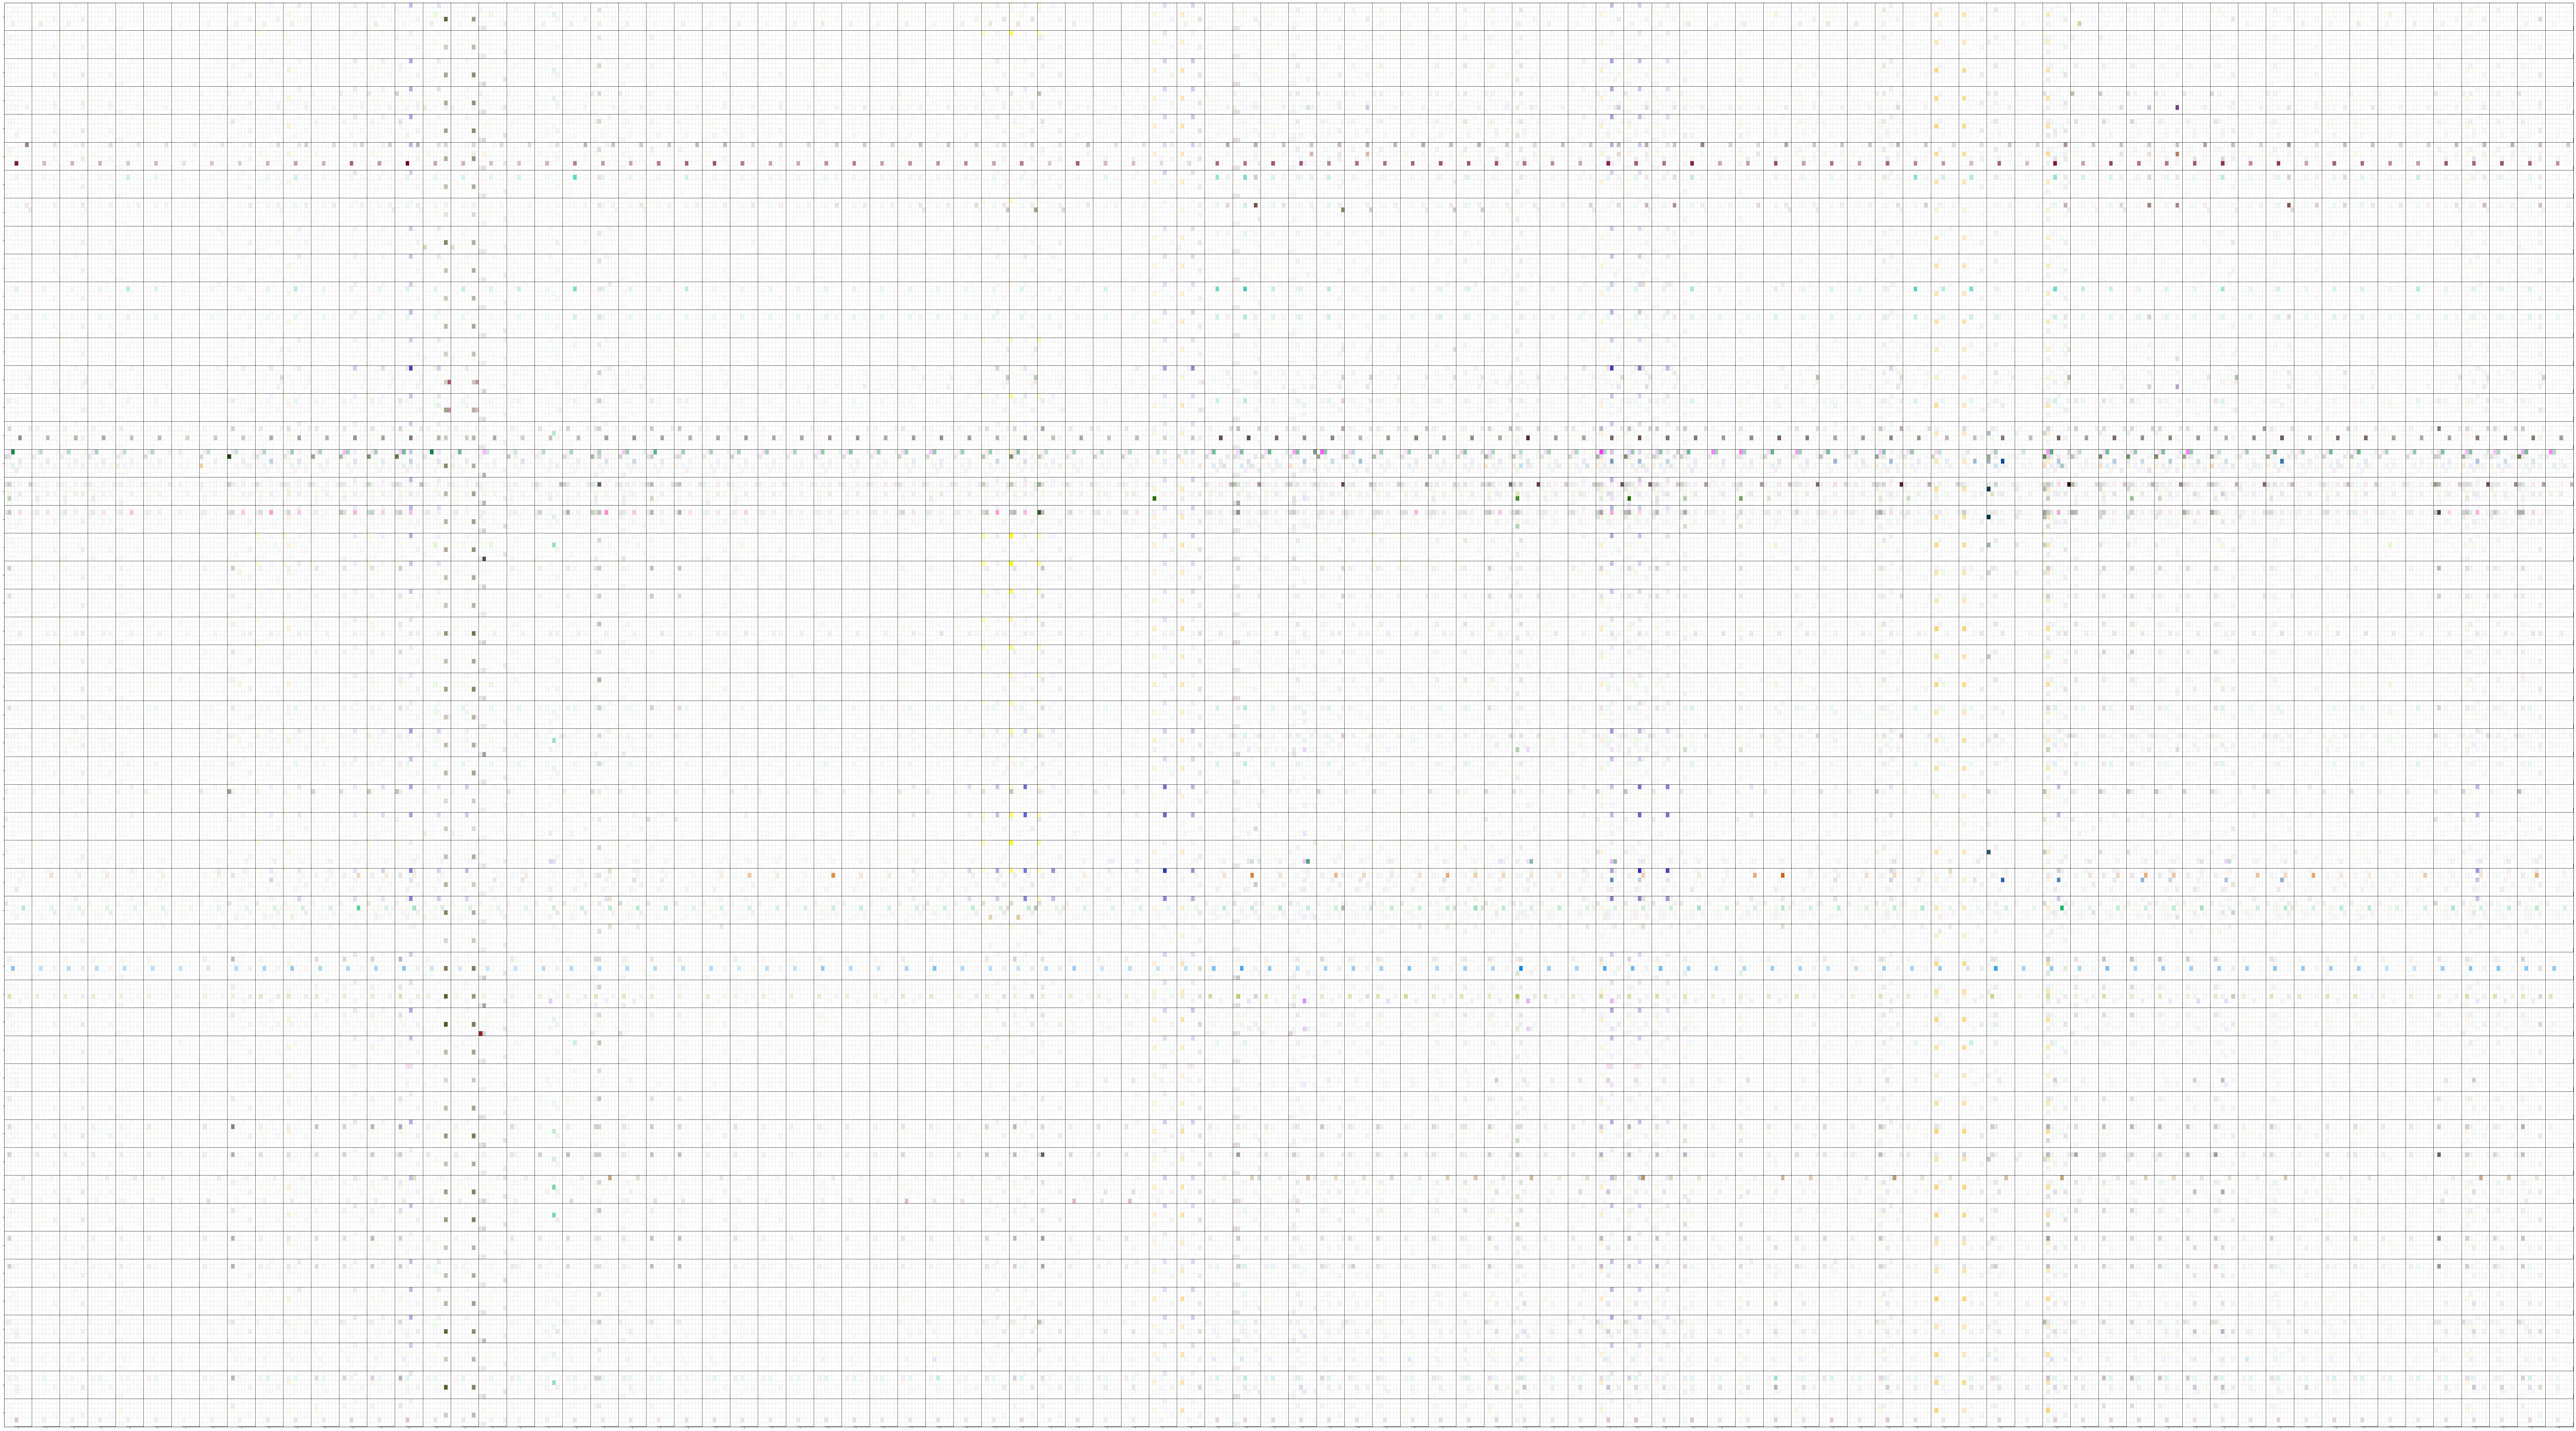

In [8]:
# SECTION 7: make magical rainbow heatmap
# ─────────────────────────────────────────────────────────────────────────────

ligand_names = interaction_scores_array.coords['var'].values
score_tensor = interaction_scores_array.median('species').values
score_tensor = score_tensor/score_tensor.max(0).max(0)[np.newaxis,np.newaxis,:]

mask_rows = neighborhoods.isin(['T','DMR']) & ~sl_df.index.str.lower().str.contains('mix|l-q')
mask_cols = (neighborhoods != 'Neighbor') & ~sl_df.index.str.lower().str.contains('mix|l-q')

plot_tile_heatmap(
    score_tensor[mask_rows, ...][:, mask_cols, :],
    dim_0_names     = ['' for x in mask_rows if x],#interaction_scores_array.coords['ligand'].values[mask_rows],
    dim_1_names     = ['' for x in mask_cols if x],#interaction_scores_array.coords['ligand'].values[mask_cols],
    dim_2_names     = ['' for x in interaction_scores_array.coords['var'].values],
    cell_size       = 1,
    heavy_linewidth = 2,
    light_linewidth = 0.1,
    cmap_name       = 'godsnot_102',
    font_size       = 24,
    save_path       = os.path.join(sc.settings.figdir, 'Ligand-Receptor_megaheatmap.png'),
)

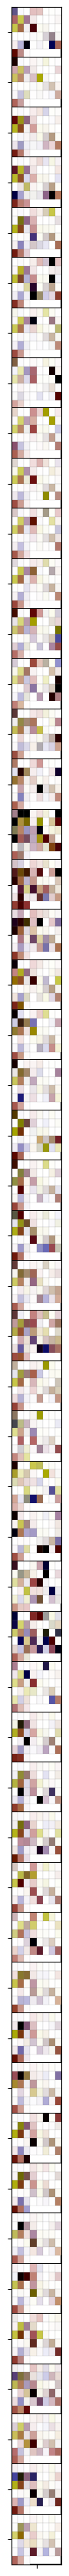

100%|██████████| 51/51 [00:03<00:00, 12.78it/s]
/scratch/fast/1596130/ipykernel_3154265/3443080384.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/scratch/fast/1596130/ipykernel_3154265/3443080384.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


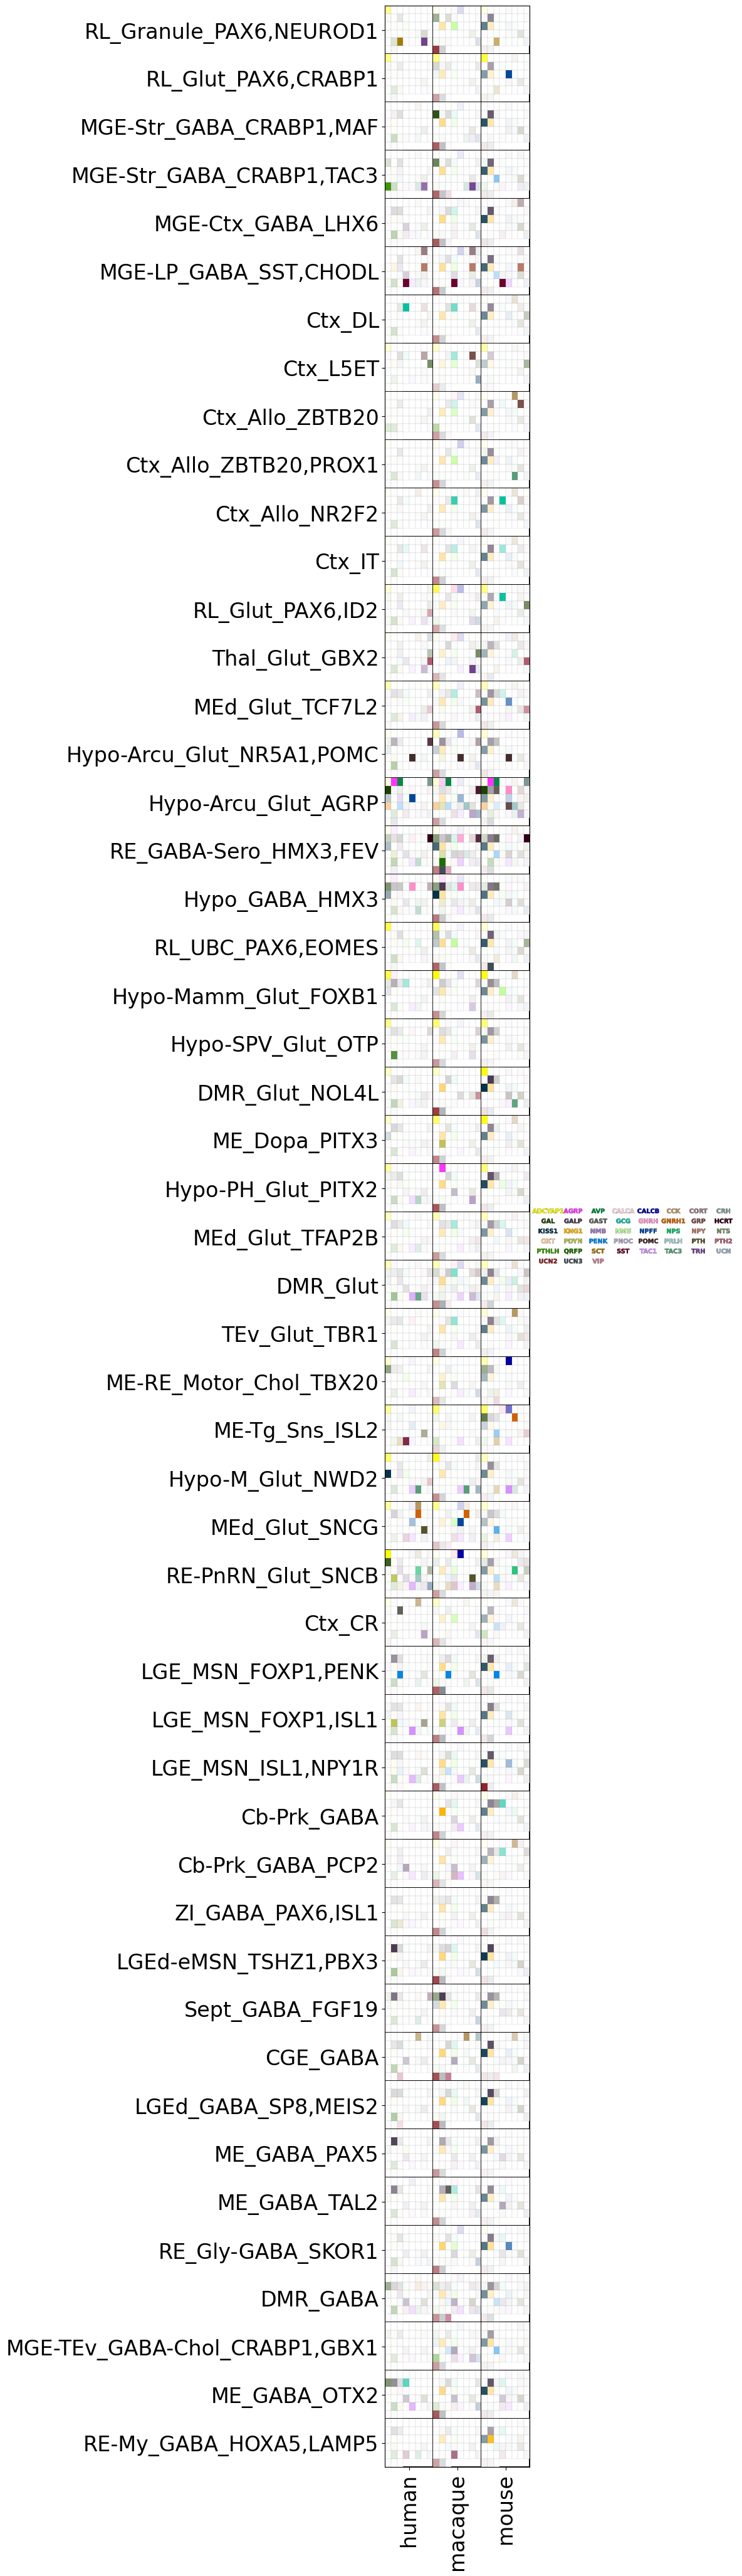

In [9]:
# lig_df = sl_df.loc[mask_rows,lig_rec['ligand'].unique()]
# plot_tile_heatmap(
#     lig_df.to_numpy()[:,np.newaxis,:],
#     dim_0_names     = list(lig_df.index),
#     dim_1_names     = list(['']),
#     dim_2_names     = lig_df.columns,
#     cell_size       = 1,
#     heavy_linewidth = 2,
#     light_linewidth = 0.1,
#     cmap_name       = 'godsnot_102',
#     save_path       = os.path.join(sc.settings.figdir, 'Ligand_megaheatmap.svg'),
# )

data = species_scaled.sel(var=lig_rec['ligand'].unique()).values[:,mask_rows,np.newaxis,:]
plot_tile_heatmap_rgb(
    tile_colors     = compute_tricolor_rgb_4d(data,black_exp=1.),
    dim_0_names     = ['' for x in mask_rows if x],#interaction_scores_array.coords['ligand'].values[mask_rows],
    dim_1_names     = list(['']),
    dim_2_names     = interaction_scores_array.coords['var'].values,
    cell_size       = 1,
    heavy_linewidth = 2,
    light_linewidth = 0.1,
    font_size       = 24,
    save_path       = os.path.join(sc.settings.figdir, 'Ligand_diffs_megaheatmap.png'),
)

spec_dfs = []
for s in species_scaled.coords['species'].values:
    this_df = pd.DataFrame(
        species_scaled.sel(species=s), 
        index=species_scaled.coords['Initial_Class_markers'].values,
        columns=species_scaled.coords['var'].values
    )
    spec_dfs.append(this_df.loc[mask_rows,lig_rec['ligand'].unique()])

plot_tile_heatmap(
    np.stack([df.to_numpy() for df in spec_dfs],axis=1),
    dim_0_names     = list(spec_dfs[0].index),
    dim_1_names     = list(species_scaled.coords['species'].values),
    dim_2_names     = list(spec_dfs[0].columns),
    cell_size       = 1,
    heavy_linewidth = 2,
    light_linewidth = 0.1,
    cmap_name       = 'godsnot_102',
    font_size       = 24,
    save_path       = os.path.join(sc.settings.figdir, f'Ligand_species_megaheatmap.svg'),
)


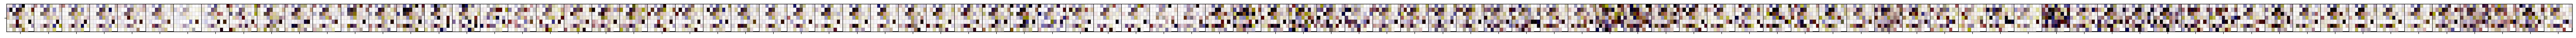

100%|██████████| 3/3 [00:11<00:00,  3.97s/it]
/scratch/fast/1596130/ipykernel_3154265/3443080384.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/scratch/fast/1596130/ipykernel_3154265/3443080384.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


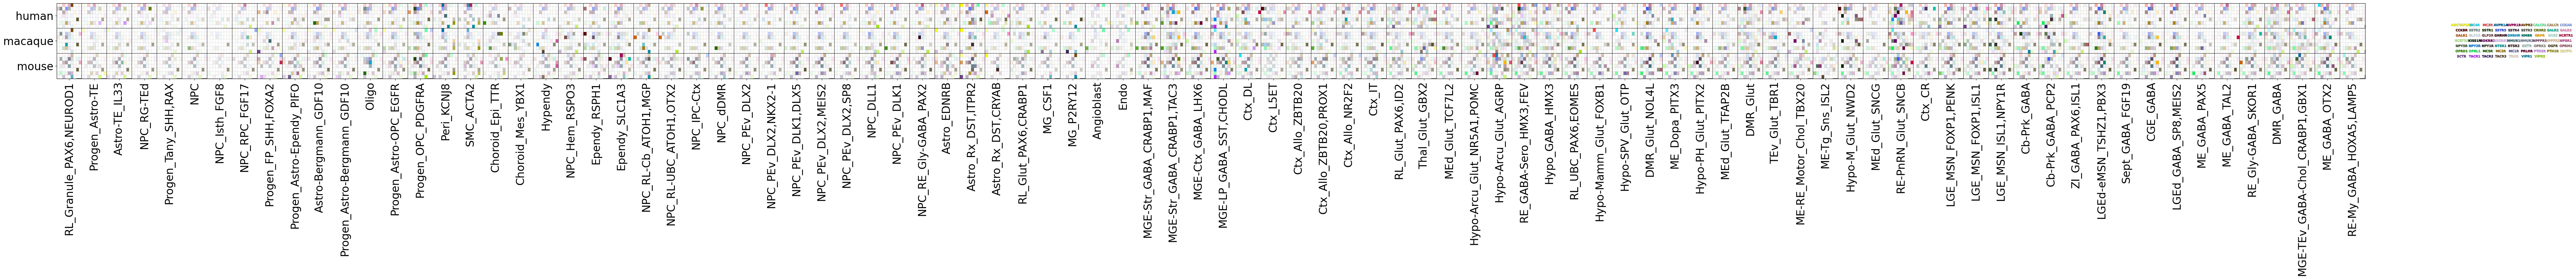

In [10]:
# rec_df = sl_df.loc[mask_cols,lig_rec['receptor'].unique()]
# plot_tile_heatmap(
#     rec_df.to_numpy()[np.newaxis,:,:],
#     dim_0_names     = list(['']),
#     dim_1_names     = list(rec_df.index),
#     dim_2_names     = rec_df.columns,
#     cell_size       = 1,
#     heavy_linewidth = 2,
#     light_linewidth = 0.1,
#     cmap_name       = 'godsnot_102',
#     save_path       = os.path.join(sc.settings.figdir, 'Receptor_megaheatmap.svg'),
# )

data = species_scaled.sel(var=lig_rec['receptor'].unique()).values[:,np.newaxis,mask_cols,:]
plot_tile_heatmap_rgb(
    tile_colors     = compute_tricolor_rgb_4d(data,black_exp=1.),
    dim_0_names     = list(['']),
    dim_1_names     = ['' for x in mask_cols if x],#interaction_scores_array.coords['receptor'].values[mask_cols],
    dim_2_names     = lig_rec['receptor'].unique(),
    cell_size       = 1,
    heavy_linewidth = 2,
    light_linewidth = 0.1,
    font_size       = 24,
    save_path       = os.path.join(sc.settings.figdir, 'Receptor_diffs_megaheatmap.png'),
)

spec_dfs = []
for s in species_scaled.coords['species'].values:
    this_df = pd.DataFrame(
        species_scaled.sel(species=s), 
        index=species_scaled.coords['Initial_Class_markers'].values,
        columns=species_scaled.coords['var'].values
    )
    spec_dfs.append(this_df.loc[mask_cols,lig_rec['receptor'].unique()])

plot_tile_heatmap(
    np.stack([df.to_numpy() for df in spec_dfs],axis=0),
    dim_0_names     = list(species_scaled.coords['species'].values),
    dim_1_names     = list(spec_dfs[0].index),
    dim_2_names     = list(spec_dfs[0].columns),
    cell_size       = 1,
    heavy_linewidth = 2,
    light_linewidth = 0.1,
    cmap_name       = 'godsnot_102',
    font_size       = 24,
    save_path       = os.path.join(sc.settings.figdir, f'Receptor_species_megaheatmap.svg'),
)

3162


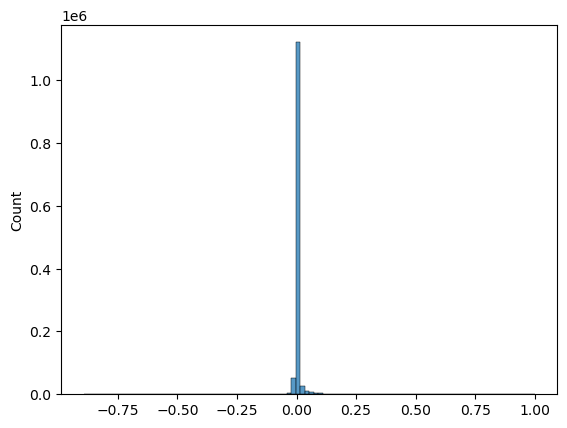

In [11]:
seaborn.histplot((species_interactions - np.median(species_interactions,0)).flatten(),bins=100)
print((np.abs((species_interactions - np.median(species_interactions,0)))>0.2).sum())

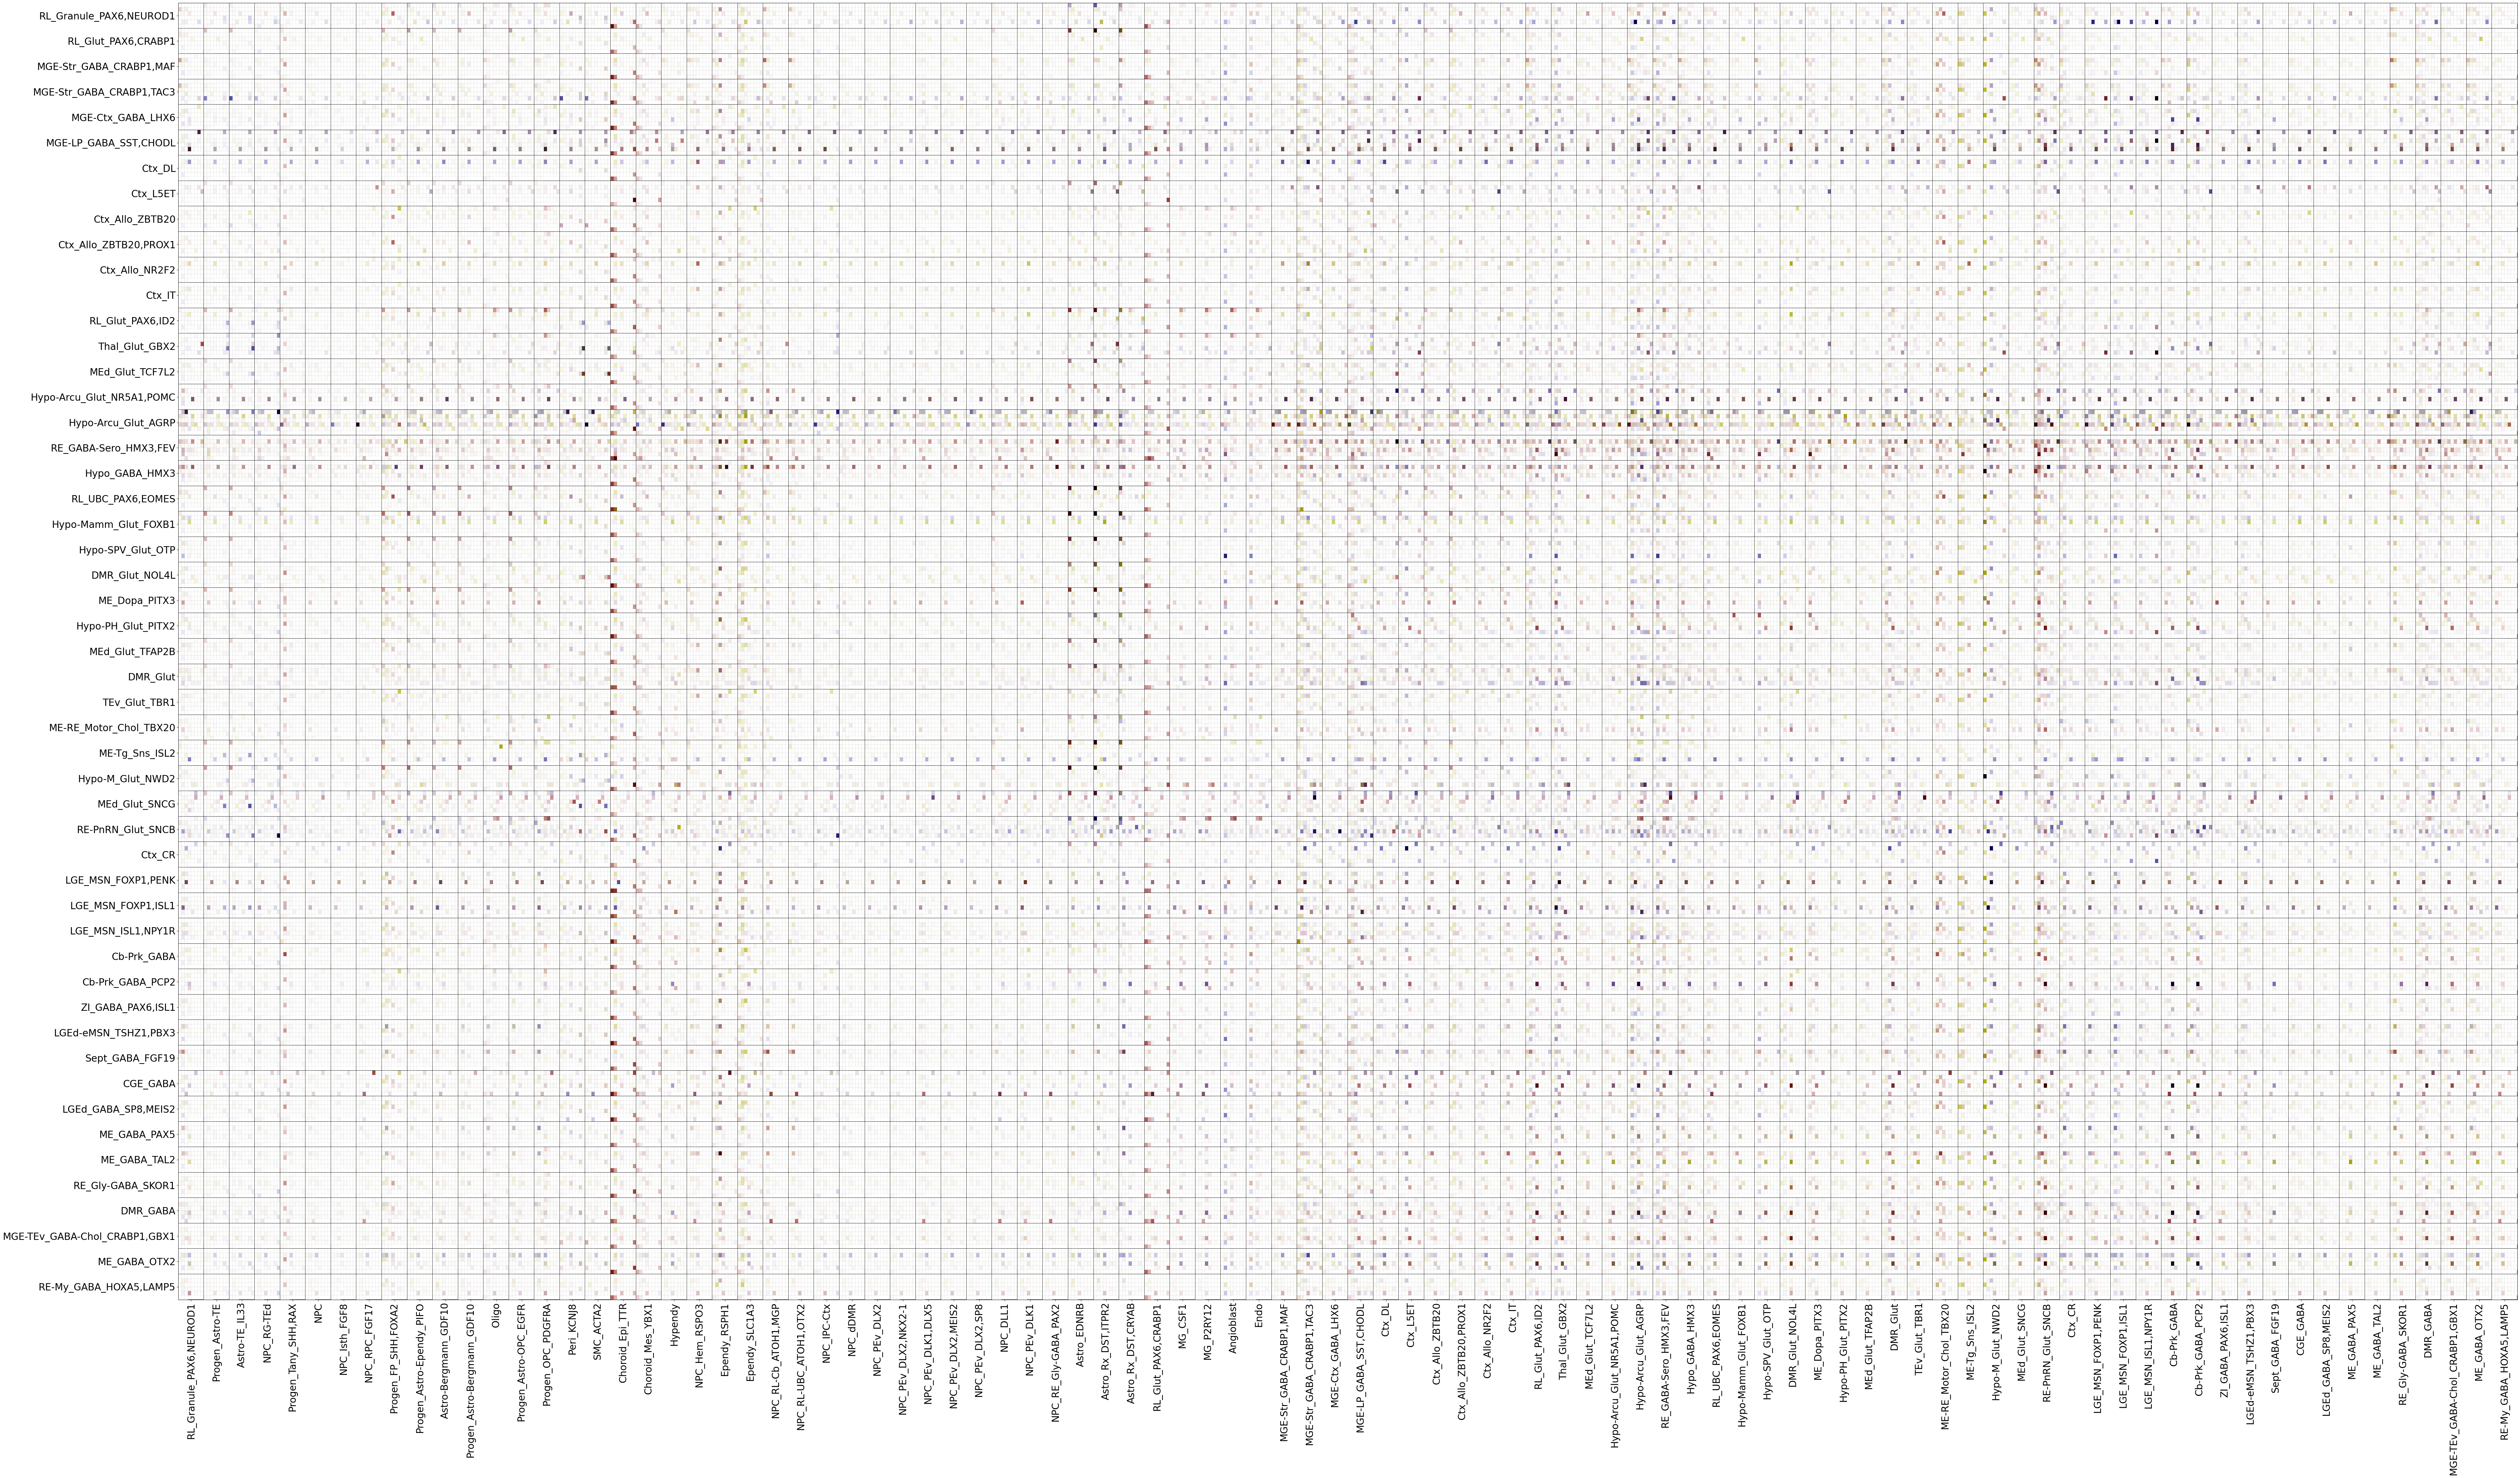

In [12]:
data = species_interactions[:,mask_rows,:,:][:,:, mask_cols, :]
# abs_max = np.max(np.abs(data))
# d = (data / (2*abs_max)) + 0.5

rgb_colors = compute_tricolor_rgb_4d(data,black_exp=1)

plot_tile_heatmap_rgb(
    tile_colors = rgb_colors,
    dim_0_names     = list(sl_df.index[mask_rows]),
    dim_1_names     = list(sl_df.index[mask_cols]),
    dim_2_names     = ligand_names,
    cell_size       = 1,
    heavy_linewidth = 2,
    light_linewidth = 0.1,
    font_size       = 24,    
    save_path       = os.path.join(sc.settings.figdir, 'Ligand-Receptor_divergence_megaheatmap.png'),
)



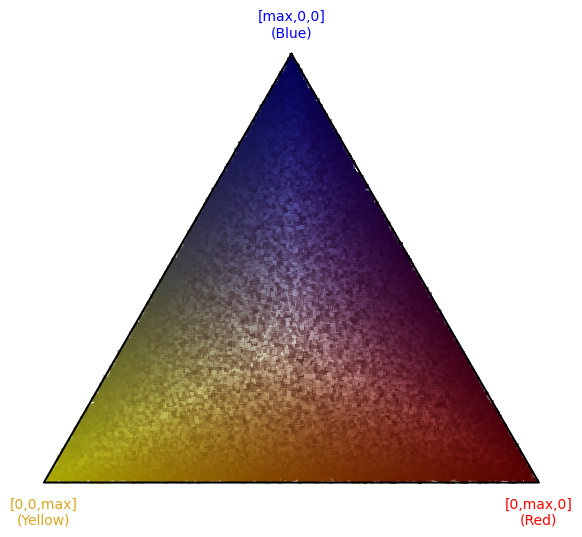

In [13]:
plot_tricolor_legend_4d(N=1000000,save_prefix=os.path.join(sc.settings.figdir, 'ligand_receptor'),black_exp=1.)
# plot_simple_rby_legend()

# Are receptor ligands concordant in DE shifts?

In [14]:
max_interaction_scores = interaction_scores_array.max('species') #[mask_rows,...][:,mask_cols,:] # Interaction score thresholding in any species

corrs = {}
for i in lig_rec.index:
    ligand,receptor = lig_rec.loc[i,:]
    # sig = p_values.sel({'var':ligand}).values < 0.1
    sig_bool = max_interaction_scores.sel({'var':ligand}).values > 0.1
    sig = np.stack(np.where(sig_bool),axis=0)
    if (sig.shape[0] < 1) | (sig.shape[1] < 1):
        print(sig)
        continue
    lig_vec = species_diff.sel({'var':ligand}).values[:,sig[0,:]].flatten()
    rec_vec = species_diff.sel({'var':receptor}).values[:,sig[1,:]].flatten()
    stat = scipy.stats.pearsonr(lig_vec,rec_vec).statistic
    corrs[ligand+':'+receptor] = stat


In [15]:
corrs

{'ADCYAP1:ADCYAP1R1': np.float64(0.14251666932014867),
 'AGRP:MC4R': np.float64(0.3204626648078365),
 'AGRP:MC3R': np.float64(0.039947437082062734),
 'AVP:AVPR1A': np.float64(-0.1808221896533099),
 'AVP:AVPR1B': np.float64(-0.2526582090109988),
 'AVP:AVPR2': np.float64(-0.3781128230946831),
 'CALCA:CALCRL': np.float64(-0.037788397092921436),
 'CALCA:CALCR': np.float64(0.20663609395122046),
 'CALCB:CALCRL': np.float64(0.3018308846348864),
 'CALCB:CALCR': np.float64(-0.006990141358858726),
 'CCK:CCKAR': np.float64(0.32904941018632694),
 'CCK:CCKBR': np.float64(0.2675551807711404),
 'CORT:SSTR2': np.float64(0.25096984715329207),
 'CORT:SSTR1': np.float64(-0.07937454545437868),
 'CORT:SSTR5': np.float64(-0.1634609667926259),
 'CORT:SSTR4': np.float64(0.0517487350882546),
 'CORT:SSTR3': np.float64(0.023893738033407677),
 'CRH:CRHR2': np.float64(0.3695754324979217),
 'GAL:GALR2': np.float64(0.153995039230444),
 'GAL:GALR3': np.float64(0.021405629805090726),
 'GAL:GALR1': np.float64(0.1066731

In [16]:
k = 100000
null_corrs = {}
for i,j in tqdm.tqdm(zip(np.random.choice(lig_rec.index,size=k),np.random.choice(lig_rec.index,size=k))):
    if i==j:
        continue
    ligand,dummy = lig_rec.loc[i,:]
    dummy,receptor = lig_rec.loc[j,:]

    # sig = p_values.sel({'var':ligand}).values < 0.05
    sig = max_interaction_scores.sel({'var':ligand}).values > 0.1
    sig = np.stack(np.where(sig),axis=0)

    lig_vec = species_diff.sel({'var':ligand}).values[:,sig[0,:]].flatten()
    rec_vec = species_diff.sel({'var':receptor}).values[:,sig[1,:]].flatten()
    null_corrs[ligand+':'+receptor] = scipy.stats.pearsonr(lig_vec,rec_vec).statistic

100000it [02:11, 760.04it/s]


In [17]:
corrs = np.array(list(corrs.values()))
null_corrs = np.array(list(null_corrs.values()))

In [18]:
corrs_mean = np.nanmean(corrs)
corrs_mad_mean = np.nanmean(np.abs(corrs))

In [19]:
k = len(corrs) #we wanna do the same downsampling as corrs to make sure it's not just small N extreme values
means_rej = []
mads_rej = []
for x in tqdm.tqdm(range(10000)):
    inner_null_corrs = []
    for i,j in zip(np.random.choice(lig_rec.index,size=k),np.random.choice(lig_rec.index,size=k)):
        if i == j:
            continue
        ligand,dummy = lig_rec.loc[i,:]
        dummy,receptor = lig_rec.loc[j,:]
        sig = max_interaction_scores.sel({'var':ligand}).values > 0.1
        # sig = p_values.sel({'var':ligand}).values < 0.05
        sig = np.stack(np.where(sig),axis=0)
        lig_vec = species_diff.sel({'var':ligand}).values[:,sig[0,:]].flatten()
        rec_vec = species_diff.sel({'var':receptor}).values[:,sig[1,:]].flatten()
        inner_null_corrs.append(scipy.stats.pearsonr(lig_vec,rec_vec).statistic)
    means_rej.append(np.nanmean(np.array(inner_null_corrs)) > corrs_mean)
    mads_rej.append(np.nanmean(np.abs(np.array(inner_null_corrs))) > corrs_mad_mean)

100%|██████████| 10000/10000 [20:52<00:00,  7.99it/s]


In [20]:
print('mean cor significant pair divergence corr',np.nanmean(corrs))
print('mean cor significant pair divergence corr null',np.nanmean(null_corrs))
print(f'mean cor resampling pval {'<' if np.sum(means_rej)==0 else ''}=',np.nanmean(means_rej+[1.]))


mean cor significant pair divergence corr 0.08905844713143106
mean cor significant pair divergence corr null 0.012428830693454549
mean cor resampling pval <= 9.999000099990002e-05


In [21]:
print('abs cor significant pair divergence corr',np.nanmean(np.abs(corrs)))
print('abs cor significant pair divergence corr null',np.nanmean(np.abs(null_corrs)))
print(f'abs cor resampling pval {'<' if np.sum(mads_rej)==0 else ''}=',np.nanmean(mads_rej+[1.]))


abs cor significant pair divergence corr 0.1696457554060843
abs cor significant pair divergence corr null 0.12806973222257365
abs cor resampling pval = 0.0021997800219978004


In [22]:
k = 100000
null_corrs = {}
for i,j in tqdm.tqdm(zip(np.random.choice(lig_rec.index,size=k),np.random.choice(lig_rec.index,size=k))):
    if i==j:
        continue
    ligand,dummy = lig_rec.loc[i,:]
    dummy,receptor = lig_rec.loc[j,:]

    # sig = p_values.sel({'var':ligand}).values < 0.05
    sig = max_interaction_scores.sel({'var':ligand}).values > 0.1
    sig = np.stack(np.where(sig),axis=0)

    lig_vec = species_diff.sel({'var':ligand}).values[:,sig[0,:]].flatten()
    rec_vec = species_diff.sel({'var':receptor}).values[:,sig[1,:]].flatten()
    null_corrs[ligand+':'+receptor] = scipy.stats.pearsonr(lig_vec,rec_vec).statistic
max_interaction_scores = interaction_scores_array.max('species') #[mask_rows,...][:,mask_cols,:] # Interaction score thresholding in any species

corrs = {}
for i in lig_rec.index:
    ligand,receptor = lig_rec.loc[i,:]
    # sig = p_values.sel({'var':ligand}).values < 0.1
    sig_bool = max_interaction_scores.sel({'var':ligand}).values > 0.1
    sig = np.stack(np.where(sig_bool),axis=0)
    if (sig.shape[0] < 1) | (sig.shape[1] < 1):
        print(sig)
        continue
    lig_vec = species_diff.sel({'var':ligand}).values[:,sig[0,:]].flatten()
    rec_vec = species_diff.sel({'var':receptor}).values[:,sig[1,:]].flatten()
    stat = scipy.stats.pearsonr(lig_vec,rec_vec).statistic
    corrs[ligand+':'+receptor] = stat

corrs = np.array(list(corrs.values()))
null_corrs = np.array(list(null_corrs.values()))

100000it [02:13, 747.27it/s]


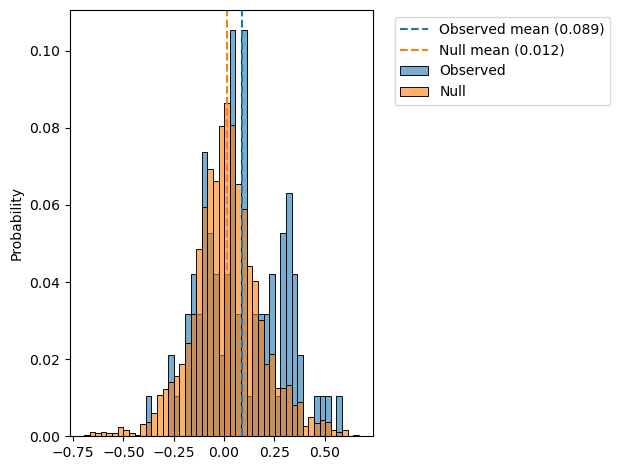

In [23]:
bins = np.linspace(
    min(corrs.min(), null_corrs.min()),
    max(corrs.max(), null_corrs.max()),
    50
)

# compute means
mean_corr     = np.mean(corrs)
mean_null_corr = np.mean(null_corrs)

plt.figure()
seaborn.histplot(
    corrs,
    bins=bins,
    stat='probability',
    color='C0',
    label='Observed',
    alpha=0.6
)
seaborn.histplot(
    null_corrs,
    bins=bins,
    stat='probability',
    color='C1',
    label='Null',
    alpha=0.6
)

# vertical lines at the means
plt.axvline(
    mean_corr,
    color='C0',
    linestyle='--',
    linewidth=1.5,
    label=f'Observed mean ({mean_corr:.3f})'
)
plt.axvline(
    mean_null_corr,
    color='C1',
    linestyle='--',
    linewidth=1.5,
    label=f'Null mean ({mean_null_corr:.3f})'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(
    os.path.join(sc.settings.figdir, 'lr_pair_correlations.svg'),
    format='svg'
)


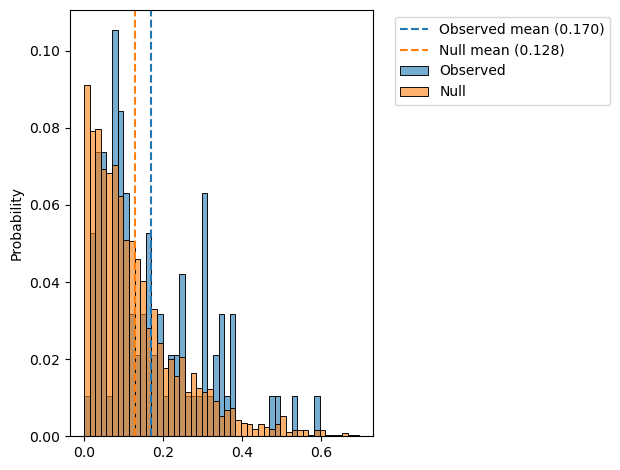

In [24]:
abs_corrs = np.abs(corrs)
null_abs_corrs = np.abs(null_corrs)

bins = np.linspace(
    min(abs_corrs.min(), null_abs_corrs.min()),
    max(abs_corrs.max(), null_abs_corrs.max()),
    50
)

# compute means
mean_corr     = np.mean(abs_corrs)
mean_null_corr = np.mean(null_abs_corrs)

plt.figure()
seaborn.histplot(
    abs_corrs,
    bins=bins,
    stat='probability',
    color='C0',
    label='Observed',
    alpha=0.6
)
seaborn.histplot(
    null_abs_corrs,
    bins=bins,
    stat='probability',
    color='C1',
    label='Null',
    alpha=0.6
)

# vertical lines at the means
plt.axvline(
    mean_corr,
    color='C0',
    linestyle='--',
    linewidth=1.5,
    label=f'Observed mean ({mean_corr:.3f})'
)
plt.axvline(
    mean_null_corr,
    color='C1',
    linestyle='--',
    linewidth=1.5,
    label=f'Null mean ({mean_null_corr:.3f})'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(
    os.path.join(sc.settings.figdir, 'lr_pair_abs_correlations.svg'),
    format='svg'
)


In [25]:
dfdfdfsdfsdfsdf

NameError: name 'dfdfdfsdfsdfsdf' is not defined

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Tricolor ligand differential‐expression heatmap
# ─────────────────────────────────────────────────────────────────────────────
# plot_tricolor_heatmap(
#     np.array(ligand_differences),
#     y_tick_labels    = np.array(ligand_differences.coords['Initial_Class_markers']),
#     x_tick_labels    = np.array(ligand_differences.coords['var']),
#     color_axes       = np.array(ligand_differences.coords['species']),
#     heatmap_figsize  = (10, 10),
#     legend_figsize   = (6, 6),
#     save_prefix      = os.path.join(sc.settings.figdir, 'tricolor_realDE_ligands'),
# )

# ─────────────────────────────────────────────────────────────────────────────
# Tricolor receptor differential‐expression heatmap
# ─────────────────────────────────────────────────────────────────────────────
# plot_tricolor_heatmap(
#     np.array(receptor_differences),
#     y_tick_labels    = np.array(receptor_differences.coords['Initial_Class_markers']),
#     x_tick_labels    = np.array(receptor_differences.coords['var']),
#     color_axes       = np.array(receptor_differences.coords['species']),
#     heatmap_figsize  = (16, 12),
#     legend_figsize   = (6, 6),
#     save_prefix      = os.path.join(sc.settings.figdir, 'tricolor_realDE_receptors'),
# )


In [ ]:
pstore = adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels, zero_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
keep_clusters = np.array([x in adata.obs['level_2'].unique() for x in cluster_labels ])
cluster_labels = np.array(cluster_labels)[keep_clusters]
zero_mask = zero_mask[:,keep_clusters,:]
cluster_index = np.array([int(x) for x in cluster_labels])
zero_mask = np.nan_to_num(zero_mask,posinf=np.nan)
discov_cluster_params = discov_cluster_params[:,cluster_index,:] * zero_mask
prop_locs = prop_locs[cluster_index,:]
prop_discov_di = prop_discov_di[:,cluster_index,:] * zero_mask
prop_discov_dm = prop_discov_dm[:,cluster_index,:] * zero_mask
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]

In [ ]:
def calculate_interaction_scores(expr, pairs, n_iter=1000, random_state=None):
    """
    Calculate integration scores and permutation-based significance p-values for
    receptor-ligand interactions between clusters.

    For each ligand (and its receptors) present in the expression DataFrame, we compute:
      - Observed score: outer(L, R_mean) where L is the ligand expression (per cluster)
        and R_mean is the mean receptor expression across valid receptors (per cluster).
      - Null distribution: For each permutation, both L and each receptor column in R
        are shuffled independently across clusters and then averaged. The null score
        is computed as outer(L_perm, R_perm_mean).

    The p-value for each cluster pair (i, j) is calculated as the fraction of permutations
    where the null score at (i, j) is greater than or equal to the observed score.

    Parameters
    ----------
    expr : pandas.DataFrame
        Rows are clusters and columns are gene names (scaled expression values).
    pairs : pandas.DataFrame
        Must contain columns 'ligand' and 'receptor' with receptor-ligand pairs.
    n_iter : int, optional
        Number of random permutations for the significance test (default is 1000).
    random_state : int or None, optional
        Random seed for reproducibility.

    Returns
    -------
    interaction_scores : dict
        Dictionary mapping each ligand to its observed interaction score matrix (n_clusters x n_clusters).
    p_values : dict
        Dictionary mapping each ligand to its corresponding p-value matrix (n_clusters x n_clusters).
    """
    rng = np.random.default_rng(random_state)
    interaction_scores = {}
    p_values = {}
    clusters = expr.index.values
    n_clusters = len(clusters)

    # Group receptor-ligand pairs by ligand.
    for ligand, group in tqdm.tqdm(pairs.groupby('ligand')):
        if ligand not in expr.columns:
            continue  # skip ligands not present in expr

        # Get unique receptors for this ligand that are present in expr.
        receptors = group['receptor'].unique()
        valid_receptors = [r for r in receptors if r in expr.columns]
        if not valid_receptors:
            continue

        # Extract ligand expression (per cluster) and receptor expressions.
        L = expr[ligand].values            # shape: (n_clusters,)
        R = np.column_stack([expr[r].values for r in valid_receptors])  # shape: (n_clusters, m)

        # Observed score using the mean receptor expression.
        R_mean = R.mean(axis=1)            # shape: (n_clusters,)
        observed = np.outer(L, R_mean)       # shape: (n_clusters, n_clusters)

        # Permutation test:
        # Permute ligand expression independently.
        L_perm = np.array([rng.permutation(L) for _ in range(n_iter)])  # shape: (n_iter, n_clusters)

        # Permute each receptor column independently, then average.
        permuted_R_list = []
        for j in range(R.shape[1]):
            perms = np.array([rng.permutation(R[:, j]) for _ in range(n_iter)])  # shape: (n_iter, n_clusters)
            permuted_R_list.append(perms)
        permuted_R = np.stack(permuted_R_list, axis=-1)   # shape: (n_iter, n_clusters, m)
        R_perm_mean = permuted_R.mean(axis=-1)            # shape: (n_iter, n_clusters)

        # Compute null scores: for each iteration, outer product of permuted ligand and receptor.
        # null_scores[r, i, j] = L_perm[r, i] * R_perm_mean[r, j]
        null_scores = L_perm[:, :, None] * R_perm_mean[:, None, :]  # shape: (n_iter, n_clusters, n_clusters)

        # For each cluster pair (i, j), p-value is the fraction of permutations where the
        # null score is greater than or equal to the observed score.
        p_matrix = (np.sum(null_scores >= observed[None, :, :], axis=0) + 1) / (n_iter + 1)

        interaction_scores[ligand] = observed
        p_values[ligand] = p_matrix

    return interaction_scores, p_values




In [ ]:
interaction_scores, p_values = calculate_interaction_scores(
    sl_df, lig_rec, n_iter=int(1e5), random_state=13
)

adj_p_values = {k:adjust_pvalues_matrix(p_values[k], alpha=0.01, method='fdr_bh')[0] for k in p_values.keys()}


In [ ]:
sc.tl.dendrogram(adata,groupby='Initial_Class_markers',use_rep='X_antipode',linkage_method='ward')

In [ ]:

# In[ ]:


use_cat = 'Initial_Class_markers'
for k in interaction_scores.keys():
    # seaborn.clustermap(interaction_scores[k],cmap='Purples',vmin=0)
    seaborn.heatmap(interaction_scores[k][adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered'],:][:,adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered']],cmap='Purples',vmin=0)
    plt.xlabel('receptor cluster')
    plt.ylabel('ligand cluster')
    plt.title(k)
    plt.show()
    seaborn.heatmap(-np.log10(p_values[k][adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered'],:][:,adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered']]),cmap='Purples',vmin=0)
    plt.xlabel('receptor cluster')
    plt.ylabel('ligand cluster')
    plt.title(k+' pvalues')
    plt.show()
    seaborn.heatmap(-np.log10(adj_p_values[k][adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered'],:][:,adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered']]),cmap='Purples',vmin=0)
    plt.xlabel('receptor cluster')
    plt.ylabel('ligand cluster')
    plt.title(k+' pvalues')
    plt.show()


In [ ]:
def calculate_interaction_scores(expr, pairs, n_iter=1000, random_state=None):
    """
    Calculate integration scores and permutation-based significance p-values for
    receptor-ligand interactions between clusters.

    For each ligand (and its receptors) present in the expression DataFrame, we compute:
      - Observed score: outer(L, R_mean) where L is the ligand expression (per cluster)
        and R_mean is the mean receptor expression across valid receptors (per cluster).
      - P-values: For each cell in the observed matrix, the p-value is computed as the
        fraction of products (sampled from the null distribution) that are greater than or
        equal to the observed value.

    The null distribution is defined globally by taking all expression values for genes
    that appear as either a ligand or receptor in the `pairs` DataFrame and multiplying
    pairs of them together. This same null distribution is used for all ligands.

    Parameters
    ----------
    expr : pandas.DataFrame
        Rows are clusters and columns are gene names (scaled expression values).
    pairs : pandas.DataFrame
        Must contain columns 'ligand' and 'receptor' with receptor-ligand pairs.
    n_iter : int, optional
        Number of samples for the null distribution (default is 1000).
    random_state : int or None, optional
        Random seed for reproducibility.

    Returns
    -------
    interaction_scores : dict
        Dictionary mapping each ligand to its observed interaction score matrix (n_clusters x n_clusters).
    p_values : dict
        Dictionary mapping each ligand to its corresponding p-value matrix (n_clusters x n_clusters).
    """
    rng = np.random.default_rng(random_state)
    interaction_scores = {}
    p_values = {}
    clusters = expr.index.values
    n_clusters = len(clusters)

    # Build a global pool from all relevant genes (appearing as ligand or receptor) that are present in expr.
    all_genes = set(pairs['ligand']).union(set(pairs['receptor']))
    valid_genes = [g for g in all_genes if g in expr.columns]
    global_pool = expr[valid_genes].values.flatten()

    # Generate a global null distribution:
    # Each sample is the product of two values drawn at random from the global pool.
    x_samples = rng.choice(global_pool, size=n_iter)
    y_samples = rng.choice(global_pool, size=n_iter)
    null_distribution = x_samples * y_samples  # shape: (n_iter,)

    # Process each ligand group.
    for ligand, group in tqdm.tqdm(pairs.groupby('ligand')):
        if ligand not in expr.columns:
            continue  # skip ligands not present in expr

        # Get unique receptors for this ligand that are present in expr.
        receptors = group['receptor'].unique()
        valid_receptors = [r for r in receptors if r in expr.columns]
        if not valid_receptors:
            continue

        # Observed ligand and receptor expressions.
        L = expr[ligand].values  # shape: (n_clusters,)
        R = np.column_stack([expr[r].values for r in valid_receptors])  # shape: (n_clusters, m)
        R_mean = R.mean(axis=1)  # shape: (n_clusters,)
        observed = np.outer(L, R_mean)  # shape: (n_clusters, n_clusters)

        # For each cell in the observed matrix, compute p-value as the fraction of samples in the
        # global null distribution that are greater than or equal to the observed value.
        # Broadcasting: null_distribution[:, None, None] has shape (n_iter, 1, 1) and observed has shape (n_clusters, n_clusters).
        p_matrix = (np.sum(null_distribution[:, None, None] >= observed[None, :, :], axis=0) + 1) / (n_iter + 1)

        interaction_scores[ligand] = observed
        p_values[ligand] = p_matrix

    return interaction_scores, p_values


In [ ]:
interaction_scores, p_values = calculate_interaction_scores(
    sl_df, lig_rec, n_iter=int(1e5), random_state=13
)

adj_p_values = {k:adjust_pvalues_matrix(p_values[k], alpha=0.01, method='fdr_bh')[0] for k in p_values.keys()}


In [ ]:


# In[ ]:


[adj_p_values[k].min() for k in p_values.keys()]


# In[ ]:


use_cat = 'Initial_Class_markers'
for k in interaction_scores.keys():
    # seaborn.clustermap(interaction_scores[k],cmap='Purples',vmin=0)
    seaborn.heatmap(interaction_scores[k][adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered'],:][:,adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered']],cmap='Purples',vmin=0)
    plt.xlabel('receptor cluster')
    plt.ylabel('ligand cluster')
    plt.title(k)
    plt.show()
    seaborn.heatmap(-np.log10(p_values[k][adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered'],:][:,adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered']]),cmap='Purples',vmin=0)
    plt.xlabel('receptor cluster')
    plt.ylabel('ligand cluster')
    plt.title(k+' pvalues')
    plt.show()
    seaborn.heatmap(-np.log10(adj_p_values[k][adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered'],:][:,adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered']]),cmap='Purples',vmin=0)
    plt.xlabel('receptor cluster')
    plt.ylabel('ligand cluster')
    plt.title(k+' pvalues')
    plt.show()


In [ ]:
# def boost_to_white(rgb, exponent=2.0):
#     """
#     rgb: array (..., 3), values in [0,1]
#     exponent > 1: makes “whitening” kick in more strongly at high intensity
#     Returns: same shape, pushed toward white where channels are jointly high.
    
#     We compute the per-pixel mean m = (r+g+b)/3,
#     then blend each channel c -> c' = c + (1 - c) * (m**exponent).
#     """
#     # compute mean brightness
#     m = np.mean(rgb, axis=-1, keepdims=True)   # shape (...,1)
#     alpha = m ** exponent                       # non-linear push factor
#     return np.clip(rgb + (1 - rgb) * alpha, 0, 1)

# plot_tile_heatmap_rgb(
#     tile_colors = boost_to_white(np.transpose(data,[1,2,3,0])),
#     dim_0_names     = list(sl_df.index[mask_rows]),
#     dim_1_names     = list(sl_df.index[mask_cols]),
#     dim_2_names     = ligand_names,
#     cell_size       = 1,
#     heavy_linewidth = 2,
#     light_linewidth = 0.1,
#     # cmap_name       = 'godsnot_102',
#     save_path       = os.path.join(sc.settings.figdir, 'Ligand-Receptor_divergence_megaheatmap.svg'),
# )

# test = np.array([[[[1.,0.,0.]]]])
# test = np.array([[[[0.,1.,0.]]]])
# test = boost_to_white(np.array([[[[0.6,0.8,0.7]]]]))
# # test = np.array([[[[0.6,0.8,0.7]]]])
# # test = np.array([[[[1.,1.,0.]]]])
# plot_tile_heatmap_rgb(
#     tile_colors = test,
#     dim_0_names     = [''],
#     dim_1_names     = [''],
#     dim_2_names     = [''],
#     cell_size       = 1,
#     heavy_linewidth = 2,
#     light_linewidth = 0.1,
#     # cmap_name       = 'godsnot_102',
#     save_path       = os.path.join(sc.settings.figdir, 'Ligand-Receptor_divergence_megaheatmap.svg'),
# )



In [ ]:
# def test_ligrec_directionality(
#     species_means: xr.DataArray,
#     interaction_scores: xr.DataArray,
#     lig_rec: pd.DataFrame,
#     threshold: float = 0.1,
#     agg: str = 'mean',
#     n_permutations: int = 1000,
#     random_seed: int = 0,
#     dim_celltype: str   = 'celltype',
#     dim_celltype_l: str = 'celltype_l',
#     dim_celltype_r: str = 'celltype_r',
# ):
#     """
#     Permutation test of whether ligand & receptor expression deviance
#     across species tend to go in the same (or opposite) direction,
#     **iterating over rows of lig_rec** (ligand, receptor columns).

#     Assumes:
#       - species_means has dims (species, {dim_celltype}, var=genes)
#       - interaction_scores has dims
#            (species, {dim_celltype_l}, {dim_celltype_r}, var=genes)
#       - both DataArrays have a var‐coordinate array of gene‐names,
#         so ligand/receptor names can be looked up directly.
#     """
#     rng = np.random.default_rng(random_seed)
#     sd = 'species'
#     vd = 'var'

#     # 1) sanity-check dims
#     if dim_celltype    not in species_means.dims:
#         raise ValueError(f"'{dim_celltype}' not in species_means.dims")
#     for d in (dim_celltype_l, dim_celltype_r):
#         if d not in interaction_scores.dims:
#             raise ValueError(f"'{d}' not in interaction_scores.dims")

#     # 2) pull out all lig-rec rows whose genes actually exist in var
#     genes_in_means = set(species_means.coords[vd].values)
#     valid_pairs = []
#     for _, row in lig_rec.iterrows():
#         L, R = row['ligand'], row['receptor']
#         if (L in genes_in_means) and (R in genes_in_means):
#             valid_pairs.append((L, R))
#     if not valid_pairs:
#         raise ValueError("No ligand–receptor rows where both genes are in species_means.var")

#     # 3) for each (L,R) build a mask of celltype‐pairs with score > threshold
#     #    and collect the observed dot‐products
#     entries = []
#     for L, R in valid_pairs:
#         # grab the (species,cell_l,cell_r) cube for this **pair**:
#         # we assume interaction_scores.var is gene‐based,
#         # so .sel(var=L) gives you ligand‐gene scores,
#         # but you really want the pair’s score: if you actually have a
#         # separate “pair” axis you’d pick that here instead.
#         # For now we threshold on the ligand‐gene score as a proxy:
#         pair_scores = interaction_scores.sel({vd: L})
#         if agg == 'mean':
#             m = pair_scores.mean(dim=sd) > threshold
#         elif agg == 'any':
#             m = (pair_scores > threshold).any(dim=sd)
#         else:
#             raise ValueError("agg must be 'mean' or 'any'")

#         for ctl in m.coords[dim_celltype_l].values:
#             for ctr in m.coords[dim_celltype_r].values:
#                 if not bool(m.sel({dim_celltype_l: ctl,
#                                    dim_celltype_r: ctr})):
#                     continue
#                 # demean the species‐profiles
#                 vL = species_means.sel({vd: L, dim_celltype: ctl})
#                 vR = species_means.sel({vd: R, dim_celltype: ctr})
#                 vL = vL - vL.mean(dim=sd)
#                 vR = vR - vR.mean(dim=sd)
#                 entries.append(float((vL * vR).sum(dim=sd)))

#     entries      = np.array(entries)
#     obs_same     = np.sum(entries >  0)
#     obs_opposite = np.sum(entries <  0)

#     # 4) permutation test: shuffle each receptor‐profile across species
#     S = species_means.sizes[sd]
#     perm_same = np.zeros(n_permutations, dtype=int)

#     for i in tqdm.tqdm(range(n_permutations)):
#         cnt = 0
#         for L, R in valid_pairs:
#             pair_scores = interaction_scores.sel({vd: L})
#             if agg == 'mean':
#                 m = pair_scores.mean(dim=sd) > threshold
#             else:
#                 m = (pair_scores > threshold).any(dim=sd)

#             for ctl in m.coords[dim_celltype_l].values:
#                 for ctr in m.coords[dim_celltype_r].values:
#                     if not bool(m.sel({dim_celltype_l: ctl,
#                                        dim_celltype_r: ctr})):
#                         continue
#                     vL = species_means.sel({vd: L, dim_celltype: ctl})
#                     vR = species_means.sel({vd: R, dim_celltype: ctr})
#                     vL = vL - vL.mean(dim=sd)
#                     vR = vR - vR.mean(dim=sd)

#                     # shuffle the receptor‐vector
#                     perm_idx = rng.permutation(S)
#                     vRp = vR.isel({sd: perm_idx})
#                     if float((vL * vRp).sum(dim=sd)) > 0:
#                         cnt += 1

#         perm_same[i] = cnt

#     # 5) Monte‐Carlo p‐value
#     pval_same = (np.sum(perm_same >= obs_same) + 1) / (n_permutations + 1)

#     return {
#         'obs_same':               obs_same,
#         'obs_opposite':           obs_opposite,
#         'perm_same_counts':       perm_same,
#         'p_value_same_direction': pval_same
#     }


# res = test_ligrec_directionality(
#     species_means,
#     interaction_scores_array,#.max('species'),
#     lig_rec,
#     dim_celltype='Initial_Class_markers',
#     dim_celltype_l='ligand',
#     dim_celltype_r='receptor',
#     threshold=0.1,
#     agg='mean',
#     n_permutations=100,
#     random_seed=0
# )
# print(res['obs_same'], res['p_value_same_direction'])
